# Feature Selection


# 1.0 Load Data

Import dataset

In [152]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import numpy as np

# Load the dataset
file_path = '../processed_data/data_v4-1-1_feature_engineered_sensor170.csv'
data = pd.read_csv(file_path)

Given the feature engineered data have 282 data but theres only 100~ data point which might make it hard to do feature selection. Therefore we will be dividing up into each feature engineered category and eliminate highly correlated features. 

In [153]:
data.shape

(169, 283)

In [154]:
print(data.columns)

Index(['Sensor ID', '13_10000_mean_middle', '13_16800_mean_middle',
       '13_3000_mean_middle', '13_6000_mean_middle', '13_8000_mean_middle',
       '18_10000_mean_middle', '18_16800_mean_middle', '18_3000_mean_middle',
       '18_6000_mean_middle',
       ...
       '48_10000_var_upper', '48_16800_var_upper', '48_3000_var_upper',
       '48_6000_var_upper', '48_8000_var_upper', '53_10000_var_upper',
       '53_16800_var_upper', '53_3000_var_upper', '53_6000_var_upper',
       '53_8000_var_upper'],
      dtype='object', length=283)


Getting the data ready

In [155]:
# Function to slice features by keyword while maintaining the ID column
def slice_features_by_keyword(df, keyword, id_col='Sensor ID'):
    """
    Slices the features from the DataFrame that contain the given keyword while maintaining the ID column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    keyword (str): The keyword to filter the column names.
    id_col (str): The name of the ID column to retain. Default is 'Sensor ID'.

    Returns:
    pd.DataFrame: A DataFrame containing only the columns that contain the keyword and the ID column.
    """
    print(keyword)
    # Select columns that contain the keyword
    keyword_columns = df.columns[df.columns.str.contains(keyword)]
    
    # Combine the ID column with the keyword columns
    columns_to_keep = [id_col] + list(keyword_columns)
    
    # Select the columns from the DataFrame
    sliced_df = df[columns_to_keep]
    
    return sliced_df

# 2.0 Use of Correlation
Correlation measures the strength and direction of the linear relationship between two variables.

Drop Highly Correlated Features: Remove highly correlated features to reduce redundancy.

In [156]:
# Function to drop highly positively correlated features
def drop_highly_correlated_features(df, threshold=0.8):
    corr_matrix = df.corr()
    to_drop = set()
    for i in range(corr_matrix.shape[0]):
        for j in range(i + 1, corr_matrix.shape[1]):
            if corr_matrix.iloc[i, j] > threshold:
                colname = corr_matrix.columns[j]
                to_drop.add(colname)
    reduced_df = df.drop(columns=to_drop)
    print(f"Number of Feature Dropped is {len(list(to_drop))}. Number of Features Remained is {reduced_df.shape[1]}")
    return reduced_df, list(to_drop)

In [157]:
df_mean_middle = slice_features_by_keyword(data,"16800_mean_middle")
df_mean_middle.head()

16800_mean_middle


,Sensor ID,13_16800_mean_middle,18_16800_mean_middle,23_16800_mean_middle,28_16800_mean_middle,33_16800_mean_middle,38_16800_mean_middle,43_16800_mean_middle,48_16800_mean_middle,53_16800_mean_middle
0,1,827.000000,1069.285714,1302.076923,1590.384615,1959.000000,2204.040000,2434.520000,2737.000000,3006.500000
1,2,679.000000,954.200000,1247.560000,1522.920000,1811.363636,2098.744681,2373.200000,2679.320000,1855.878049
2,3,717.727273,1020.920000,1296.674419,1584.244444,1888.600000,2147.640000,2443.326531,2721.480000,2992.840000
3,4,736.840000,1031.000000,1319.000000,1628.469388,1923.000000,2242.200000,2485.325581,2753.800000,2999.608696
4,5,742.894737,1045.697674,1332.760000,1587.480000,1902.441860,2173.638298,2457.800000,2732.181818,3058.440000


In [158]:
# Drop highly correlated features
df_mean_middle_reduced, dropped_features = drop_highly_correlated_features(df_mean_middle, threshold=0.8)

print(dropped_features)

Number of Feature Dropped is 4. Number of Features Remained is 6
['43_16800_mean_middle', '38_16800_mean_middle', '48_16800_mean_middle', '53_16800_mean_middle']


In [159]:
df_mean_middle_reduced.head()

,Sensor ID,13_16800_mean_middle,18_16800_mean_middle,23_16800_mean_middle,28_16800_mean_middle,33_16800_mean_middle
0,1,827.000000,1069.285714,1302.076923,1590.384615,1959.000000
1,2,679.000000,954.200000,1247.560000,1522.920000,1811.363636
2,3,717.727273,1020.920000,1296.674419,1584.244444,1888.600000
3,4,736.840000,1031.000000,1319.000000,1628.469388,1923.000000
4,5,742.894737,1045.697674,1332.760000,1587.480000,1902.441860


In [160]:
# Function to process data in batches and remove highly correlated features within each batch
def process_batches(df, keywords, id_col='Sensor ID', threshold=0.8):
    """
    Processes data in batches based on keywords, removing highly correlated features within each batch.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    keywords (list): List of keywords to filter the column names for each batch.
    id_col (str): The name of the ID column to retain. Default is 'Sensor ID'.
    threshold (float): The correlation threshold for dropping features. Defaults to 0.8.

    Returns:
    pd.DataFrame: A DataFrame containing the processed batches with reduced features.
    """
    processed_batches = []

    for keyword in keywords:
        sliced_data = slice_features_by_keyword(df, keyword, id_col)
        reduced_data,_ = drop_highly_correlated_features(sliced_data, threshold)
        processed_batches.append(reduced_data)

    # Combine the processed batches, ensuring to merge on the ID column
    final_df = pd.concat(processed_batches, axis=1)
    
    # Remove duplicate ID columns that might have been introduced during concatenation
    final_df = final_df.loc[:, ~final_df.columns.duplicated()]

    return final_df

def get_batch_feature_name(keyword):
    features = []
    for delay in [16800,10000,8000,6000,3000]:
        features.append(f"{delay}_{keyword}")
    return features

## Mean Range Delay features 

In [161]:
mean_middle = get_batch_feature_name("mean_middle")
df_mean_middle  = process_batches(data,mean_middle,threshold=0.8)
df_mean_middle

16800_mean_middle
Number of Feature Dropped is 4. Number of Features Remained is 6
10000_mean_middle
Number of Feature Dropped is 7. Number of Features Remained is 3
8000_mean_middle
Number of Feature Dropped is 5. Number of Features Remained is 5
6000_mean_middle
Number of Feature Dropped is 5. Number of Features Remained is 5
3000_mean_middle
Number of Feature Dropped is 6. Number of Features Remained is 4


,Sensor ID,13_16800_mean_middle,18_16800_mean_middle,23_16800_mean_middle,28_16800_mean_middle,33_16800_mean_middle,13_10000_mean_middle,18_10000_mean_middle,13_8000_mean_middle,18_8000_mean_middle,38_8000_mean_middle,53_8000_mean_middle,13_6000_mean_middle,18_6000_mean_middle,23_6000_mean_middle,53_6000_mean_middle,13_3000_mean_middle,18_3000_mean_middle,53_3000_mean_middle
0,1,827.000000,1069.285714,1302.076923,1590.384615,1959.000000,827.000000,1071.000000,827.000000,1069.612245,2248.120000,2995.000000,827.000000,1069.400000,1328.200000,2995.205128,827.000000,1069.240000,2995.000000
1,2,679.000000,954.200000,1247.560000,1522.920000,1811.363636,679.640000,943.000000,679.000000,955.560000,2117.720000,1891.240000,679.000000,954.520000,1235.000000,2951.000000,679.000000,967.260870,2945.800000
2,3,717.727273,1020.920000,1296.674419,1584.244444,1888.600000,717.880000,1029.933333,718.040000,1006.069767,2163.916667,2997.320000,717.240000,1005.960000,1296.511111,3000.440000,718.040000,1007.000000,2995.400000
3,4,736.840000,1031.000000,1319.000000,1628.469388,1923.000000,737.080000,1030.351351,736.680000,1063.240000,2224.040000,2999.000000,736.920000,1087.000000,1318.652174,2999.000000,737.160000,1028.840000,2999.000000
4,5,742.894737,1045.697674,1332.760000,1587.480000,1902.441860,743.000000,1046.102041,743.000000,1047.240000,2173.400000,2110.760000,743.000000,1046.288889,1332.920000,3034.760000,741.880000,1047.244898,3045.468085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,166,729.761905,429.122449,1303.240000,1570.902439,1892.120000,704.853659,1019.720000,728.368421,1019.640000,2164.760000,2998.920000,728.809524,1020.520000,1299.720000,2996.280000,710.680000,1019.880000,3005.480000
165,167,19786.660000,1021.051282,729.800000,1569.190476,1851.640000,712.040000,1020.200000,704.306122,1020.920000,2158.840000,2992.120000,703.727273,1021.080000,1303.000000,2993.880000,716.600000,1020.840000,2983.324324
166,168,742.440000,1010.314286,1313.320000,1588.860465,1888.760000,726.120000,1011.583333,725.720000,1011.363636,2157.666667,3007.260870,726.200000,1011.320000,1322.288889,3005.720000,725.285714,1010.600000,2997.160000
167,169,751.240000,1037.880000,1327.080000,1599.615385,1891.080000,759.000000,1049.842105,759.000000,1049.400000,2173.250000,3016.302326,759.000000,1041.880000,1317.640000,3015.631579,760.916667,1050.102041,3005.880000


In [162]:
mean_lower = get_batch_feature_name("mean_lower")

df_mean_lower  = process_batches(data,mean_lower,threshold=0.8)
df_mean_lower

16800_mean_lower
Number of Feature Dropped is 0. Number of Features Remained is 10
10000_mean_lower
Number of Feature Dropped is 0. Number of Features Remained is 10
8000_mean_lower
Number of Feature Dropped is 0. Number of Features Remained is 10
6000_mean_lower
Number of Feature Dropped is 0. Number of Features Remained is 10
3000_mean_lower
Number of Feature Dropped is 0. Number of Features Remained is 10


,Sensor ID,13_16800_mean_lower,18_16800_mean_lower,23_16800_mean_lower,28_16800_mean_lower,33_16800_mean_lower,38_16800_mean_lower,43_16800_mean_lower,48_16800_mean_lower,53_16800_mean_lower,...,53_6000_mean_lower,13_3000_mean_lower,18_3000_mean_lower,23_3000_mean_lower,28_3000_mean_lower,33_3000_mean_lower,38_3000_mean_lower,43_3000_mean_lower,48_3000_mean_lower,53_3000_mean_lower
0,1,826.166667,1059.000000,0.000000,0.000000,1958.255814,0.000000,0.000000,2712.500000,2835.0,...,0.000000,826.346939,0.000000,0.000000,0.000000,1957.731707,2154.000000,0.0,2715.0,2994.555556
1,2,678.600000,0.000000,0.000000,0.000000,0.000000,1929.666667,2351.500000,0.000000,1551.0,...,2950.363636,678.500000,943.000000,1234.911111,0.000000,1838.024390,0.000000,0.0,0.0,0.000000
2,3,0.000000,0.000000,0.000000,1561.400000,0.000000,0.000000,2403.000000,0.000000,0.0,...,0.000000,0.000000,1005.736842,0.000000,0.000000,0.000000,2155.000000,0.0,2695.0,0.000000
3,4,0.000000,1029.818182,1317.933333,0.000000,1922.789474,0.000000,2463.571429,0.000000,2969.0,...,2998.200000,0.000000,0.000000,0.000000,0.000000,1922.684211,0.000000,0.0,0.0,2998.263158
4,5,718.333333,1024.142857,0.000000,0.000000,1876.333333,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,1023.000000,0.000000,1593.857143,1902.500000,2175.000000,0.0,0.0,3021.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,166,699.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1878.789474,2173.947368,0.0,0.0,0.000000
165,167,0.000000,439.333333,0.000000,1543.000000,0.000000,2031.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,1301.700000,0.000000,0.000000,0.000000,0.0,0.0,2963.363636
166,168,0.000000,988.000000,0.000000,1563.666667,0.000000,0.000000,2375.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
167,169,0.000000,0.000000,0.000000,1577.000000,0.000000,0.000000,0.000000,2697.222222,0.0,...,2993.000000,743.000000,1023.000000,1333.000000,1579.000000,0.000000,0.000000,0.0,0.0,0.000000


In [163]:
mean_upper = get_batch_feature_name("mean_upper")
df_mean_upper  = process_batches(data,mean_upper,threshold=0.8)
df_mean_upper

16800_mean_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
10000_mean_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
8000_mean_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
6000_mean_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
3000_mean_upper
Number of Feature Dropped is 0. Number of Features Remained is 10


,Sensor ID,13_16800_mean_upper,18_16800_mean_upper,23_16800_mean_upper,28_16800_mean_upper,33_16800_mean_upper,38_16800_mean_upper,43_16800_mean_upper,48_16800_mean_upper,53_16800_mean_upper,...,53_6000_mean_upper,13_3000_mean_upper,18_3000_mean_upper,23_3000_mean_upper,28_3000_mean_upper,33_3000_mean_upper,38_3000_mean_upper,43_3000_mean_upper,48_3000_mean_upper,53_3000_mean_upper
0,1,827.195122,0.000000,1353.545455,1639.727273,1959.666667,0.0,0.0,0.000000,0.0,...,3039.727273,827.095238,0.000000,0.000000,0.000000,1959.923077,0.000000,0.000000,2809.400000,2995.444444
1,2,679.869565,0.000000,0.000000,0.000000,1835.666667,0.0,2397.0,0.000000,2371.0,...,2951.744186,679.888889,975.000000,1235.408163,0.000000,1839.857143,2123.800000,2395.000000,0.000000,0.000000
2,3,742.333333,0.000000,1320.714286,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,1008.684211,0.000000,1583.666667,0.000000,2185.857143,0.000000,2743.000000,0.000000
3,4,0.000000,1042.263158,1319.526316,1687.000000,1924.000000,0.0,0.0,0.000000,3019.0,...,2999.930233,0.000000,0.000000,0.000000,0.000000,1924.021277,0.000000,0.000000,0.000000,3000.116279
4,5,0.000000,0.000000,0.000000,0.000000,1927.000000,2199.0,0.0,2755.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,1595.842105,1903.181818,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,166,751.000000,65535.000000,0.000000,1591.444444,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1881.333333,2176.170732,2472.600000,0.000000,0.000000
165,167,0.000000,1044.000000,0.000000,1592.333333,0.000000,0.0,0.0,2741.000000,0.0,...,0.000000,0.000000,0.000000,1304.047619,0.000000,1903.000000,0.000000,0.000000,0.000000,3009.000000
166,168,0.000000,1037.545455,0.000000,1615.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,743.000000,0.000000,1324.666667,0.000000,0.000000,2179.000000,0.000000,2740.333333,0.000000
167,169,0.000000,0.000000,0.000000,1607.000000,0.000000,0.0,0.0,2744.818182,0.0,...,3040.500000,0.000000,0.000000,1336.170732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Variability Range Delay features 

In [164]:
var_middle = get_batch_feature_name("var_middle")
df_var_middle  = process_batches(data,var_middle,threshold=0.8)
df_var_middle

16800_var_middle
Number of Feature Dropped is 5. Number of Features Remained is 5
10000_var_middle
Number of Feature Dropped is 0. Number of Features Remained is 10
8000_var_middle
Number of Feature Dropped is 0. Number of Features Remained is 10
6000_var_middle
Number of Feature Dropped is 0. Number of Features Remained is 10
3000_var_middle
Number of Feature Dropped is 7. Number of Features Remained is 3


,Sensor ID,13_16800_var_middle,18_16800_var_middle,23_16800_var_middle,28_16800_var_middle,13_10000_var_middle,18_10000_var_middle,23_10000_var_middle,28_10000_var_middle,33_10000_var_middle,...,18_6000_var_middle,23_6000_var_middle,28_6000_var_middle,33_6000_var_middle,38_6000_var_middle,43_6000_var_middle,48_6000_var_middle,53_6000_var_middle,13_3000_var_middle,53_3000_var_middle
0,1,0.000000e+00,5.333333,6.283401,3.821862,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.530612,693.714286,0.000000,0.000000,0.000000,6.896327,5.439716,3.325236,0.000000,0.000000
1,2,0.000000e+00,189.387755,172.414694,129.626122,5.459592,0.000000,0.000000,9.933061,0.000000,...,164.336327,0.000000,3.977143,0.000000,135.471020,4.801772,146.050612,0.000000,0.000000,4.081633
2,3,5.040169e+00,136.646531,6.272425,6.416162,4.597551,4.654545,8.214616,6.801418,5.224490,...,7.712653,4.573737,5.432007,7.288163,6.556735,114.390204,9.015385,131.761633,4.937143,158.204082
3,4,6.014694e+00,0.000000,0.000000,399.129252,4.075102,3.123123,7.582041,1528.842449,4.176871,...,35.096774,6.987440,4.460882,4.448980,0.000000,136.888163,0.000000,0.000000,5.361633,0.000000
4,5,6.475107e+00,8.168328,5.982041,140.826122,0.000000,8.843537,7.764898,9.900408,0.000000,...,5.301010,6.687347,4.760816,0.000000,4.037787,0.000000,7.111837,158.961633,5.250612,8.037003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,166,8.185830e+00,210080.068027,271.288163,8.390244,5.678049,8.940408,7.183673,107.813878,6.258503,...,9.724082,6.981224,5.224490,4.366327,111.177143,4.040816,131.010612,130.246531,116.793469,129.887347
165,167,9.153284e+08,6.628880,305149.551020,9.523810,143.549388,8.000000,3.241026,9.854694,7.862857,...,5.381224,0.000000,6.458776,6.693878,127.764898,10.109175,121.658776,124.107755,166.530612,41.225225
166,168,1.391086e+02,8.927731,149.609796,9.408638,6.720000,8.843972,117.968980,0.000000,6.173737,...,7.079184,6.028283,6.748299,106.977959,5.721997,8.487805,4.701903,7.471020,6.000000,188.871837
167,169,1.733290e+02,150.230204,209.952653,6.348178,4.444444,6.839260,125.100408,7.829787,118.857143,...,143.046531,109.459592,7.059592,148.956735,5.931313,144.875102,130.279184,7.374111,8.163121,190.720000


In [165]:
var_lower = get_batch_feature_name("var_lower")
df_var_lower  = process_batches(data,var_lower,threshold=0.8)
df_var_lower

16800_var_lower
Number of Feature Dropped is 1. Number of Features Remained is 9
10000_var_lower
Number of Feature Dropped is 0. Number of Features Remained is 10
8000_var_lower
Number of Feature Dropped is 0. Number of Features Remained is 10
6000_var_lower
Number of Feature Dropped is 1. Number of Features Remained is 9
3000_var_lower
Number of Feature Dropped is 0. Number of Features Remained is 10


,Sensor ID,13_16800_var_lower,18_16800_var_lower,23_16800_var_lower,33_16800_var_lower,38_16800_var_lower,43_16800_var_lower,48_16800_var_lower,53_16800_var_lower,13_10000_var_lower,...,48_6000_var_lower,13_3000_var_lower,18_3000_var_lower,23_3000_var_lower,28_3000_var_lower,33_3000_var_lower,38_3000_var_lower,43_3000_var_lower,48_3000_var_lower,53_3000_var_lower
0,1,3.375887,0.000000,0.00000,2.480620,0.000000,0.000000,4.285714,0.0,1.724082,...,0.000000,2.231293,0.000000,0.000000,0.000000,5.151220,4.000000,0.0,0.0,1.616162
1,2,1.476923,0.000000,0.00000,0.000000,4229.333333,29.428571,0.000000,16480.0,0.000000,...,0.000000,1.794872,0.000000,0.355556,0.000000,4.624390,0.000000,0.0,0.0,0.000000
2,3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,4.444444,0.000000,3.550498,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,4,0.000000,4.152220,3.20000,0.819346,0.000000,2.285714,0.000000,8.0,0.000000,...,30.734694,0.000000,0.000000,0.000000,0.000000,1.194879,0.000000,0.0,0.0,2.469417
4,5,5.333333,9.142857,0.00000,5.333333,0.000000,0.000000,0.000000,0.0,2.232558,...,0.000000,0.000000,0.000000,0.000000,3.344948,1.787234,0.000000,0.0,0.0,5.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,166,128.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.819346,4.051209,0.0,0.0,0.000000
165,167,0.000000,260360.333333,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,15.907692,0.000000,0.000000,0.000000,0.0,0.0,11.054545
166,168,0.000000,4.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
167,169,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,8.444444,0.0,4.266667,...,0.000000,128.000000,0.000000,30.054054,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [166]:
var_upper = get_batch_feature_name("var_upper")
df_var_upper  = process_batches(data,var_upper,threshold=0.8)
df_var_upper

16800_var_upper
Number of Feature Dropped is 2. Number of Features Remained is 8
10000_var_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
8000_var_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
6000_var_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
3000_var_upper
Number of Feature Dropped is 0. Number of Features Remained is 10


,Sensor ID,13_16800_var_upper,18_16800_var_upper,23_16800_var_upper,28_16800_var_upper,33_16800_var_upper,38_16800_var_upper,43_16800_var_upper,13_10000_var_upper,18_10000_var_upper,...,53_6000_var_upper,13_3000_var_upper,18_3000_var_upper,23_3000_var_upper,28_3000_var_upper,33_3000_var_upper,38_3000_var_upper,43_3000_var_upper,48_3000_var_upper,53_3000_var_upper
0,1,0.760976,0.000000,4.072727,2.618182,2.276423,0.0,0.0,0.000000,0.000000,...,137.018182,0.380952,0.000000,0.000000,0.000000,2.914980,0.000000,0.000000,172.800000,1.616162
1,2,2.782609,0.000000,0.000000,0.000000,15.466667,0.0,8.0,0.000000,19.487179,...,4.004430,2.828283,0.000000,1.496599,0.000000,2.759582,3.200000,0.000000,0.000000,0.000000
2,3,2.666667,0.000000,4.571429,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,12.654339,0.000000,41.066667,0.000000,3.809524,0.000000,0.000000,0.000000
3,4,0.000000,696.091038,1.877667,0.000000,3.063830,0.0,0.0,0.000000,44.606061,...,2.923588,0.000000,0.000000,0.000000,0.000000,3.108233,0.000000,0.000000,0.000000,3.295681
4,5,0.000000,0.000000,0.000000,0.000000,10.666667,0.0,0.0,2.232558,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.731152,0.710359,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,166,0.000000,0.000000,0.000000,1.777778,0.000000,0.0,0.0,32.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,38.695035,3.395122,4.800000,0.000000,0.000000
165,167,0.000000,3.428571,0.000000,4.266667,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.948897,0.000000,0.000000,0.000000,0.000000,0.000000,11.200000
166,168,0.000000,4.072727,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.000000,...,0.000000,0.000000,0.000000,4.242424,0.000000,0.000000,7.111111,0.000000,21.333333,0.000000
167,169,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4.285714,0.000000,0.000000,3.395122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Frequency of Lower and upper

In [167]:
freq_lower = get_batch_feature_name("freq_lower")
df_freq_lower  = process_batches(data,freq_lower,threshold=0.8)
df_freq_lower

16800_freq_lower
Number of Feature Dropped is 0. Number of Features Remained is 2
10000_freq_lower
Number of Feature Dropped is 0. Number of Features Remained is 2
8000_freq_lower
Number of Feature Dropped is 0. Number of Features Remained is 2
6000_freq_lower
Number of Feature Dropped is 0. Number of Features Remained is 2
3000_freq_lower
Number of Feature Dropped is 0. Number of Features Remained is 2


,Sensor ID,delay_16800_freq_lower,delay_10000_freq_lower,delay_8000_freq_lower,delay_6000_freq_lower,delay_3000_freq_lower
0,1,102,267,167,171,140
1,2,55,174,131,164,129
2,3,6,5,8,10,48
3,4,136,42,41,148,76
4,5,22,98,137,130,95
...,...,...,...,...,...,...
164,166,5,0,12,8,76
165,167,6,1,0,47,51
166,168,11,41,0,15,0
167,169,19,22,87,42,42


In [168]:
freq_upper = get_batch_feature_name("freq_upper")
df_freq_upper = process_batches(data,freq_upper,threshold=0.8)
df_freq_upper


16800_freq_upper
Number of Feature Dropped is 0. Number of Features Remained is 2
10000_freq_upper
Number of Feature Dropped is 0. Number of Features Remained is 2
8000_freq_upper
Number of Feature Dropped is 0. Number of Features Remained is 2
6000_freq_upper
Number of Feature Dropped is 0. Number of Features Remained is 2
3000_freq_upper
Number of Feature Dropped is 0. Number of Features Remained is 2


,Sensor ID,delay_16800_freq_upper,delay_10000_freq_upper,delay_8000_freq_upper,delay_6000_freq_upper,delay_3000_freq_upper
0,1,105,258,197,182,131
1,2,59,172,145,194,143
2,3,13,21,11,8,52
3,4,127,57,49,150,90
4,5,13,91,128,139,82
...,...,...,...,...,...,...
164,166,13,0,11,4,94
165,167,16,21,0,47,49
166,168,12,51,0,17,0
167,169,12,23,97,51,41


## Merge all dataframe

In [169]:
def merge_dataframes_on_sensor_id(dfs, id_col='Sensor ID'):
    """
    Merges multiple DataFrames on the specified ID column.

    Parameters:
    dfs (list of pd.DataFrame): List of DataFrames to be merged.
    id_col (str): The name of the ID column to merge on. Default is 'Sensor ID'.

    Returns:
    pd.DataFrame: The merged DataFrame.
    """
    # Start with the first DataFrame
    merged_df = dfs[0]

    # Iteratively merge the remaining DataFrames
    for df in dfs[1:]:
        merged_df = merged_df.merge(df, on=id_col, how='outer')
    
    return merged_df

In [170]:
df_corr_selected = [df_mean_middle,df_mean_lower,df_mean_upper
           ,df_var_middle,df_var_lower,df_var_upper
           ,df_freq_lower,df_freq_upper ]

df = merge_dataframes_on_sensor_id(df_corr_selected)

In [171]:
data.shape

(169, 283)

In [172]:
df

,Sensor ID,13_16800_mean_middle,18_16800_mean_middle,23_16800_mean_middle,28_16800_mean_middle,33_16800_mean_middle,13_10000_mean_middle,18_10000_mean_middle,13_8000_mean_middle,18_8000_mean_middle,...,delay_16800_freq_lower,delay_10000_freq_lower,delay_8000_freq_lower,delay_6000_freq_lower,delay_3000_freq_lower,delay_16800_freq_upper,delay_10000_freq_upper,delay_8000_freq_upper,delay_6000_freq_upper,delay_3000_freq_upper
0,1,827.000000,1069.285714,1302.076923,1590.384615,1959.000000,827.000000,1071.000000,827.000000,1069.612245,...,102,267,167,171,140,105,258,197,182,131
1,2,679.000000,954.200000,1247.560000,1522.920000,1811.363636,679.640000,943.000000,679.000000,955.560000,...,55,174,131,164,129,59,172,145,194,143
2,3,717.727273,1020.920000,1296.674419,1584.244444,1888.600000,717.880000,1029.933333,718.040000,1006.069767,...,6,5,8,10,48,13,21,11,8,52
3,4,736.840000,1031.000000,1319.000000,1628.469388,1923.000000,737.080000,1030.351351,736.680000,1063.240000,...,136,42,41,148,76,127,57,49,150,90
4,5,742.894737,1045.697674,1332.760000,1587.480000,1902.441860,743.000000,1046.102041,743.000000,1047.240000,...,22,98,137,130,95,13,91,128,139,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,166,729.761905,429.122449,1303.240000,1570.902439,1892.120000,704.853659,1019.720000,728.368421,1019.640000,...,5,0,12,8,76,13,0,11,4,94
165,167,19786.660000,1021.051282,729.800000,1569.190476,1851.640000,712.040000,1020.200000,704.306122,1020.920000,...,6,1,0,47,51,16,21,0,47,49
166,168,742.440000,1010.314286,1313.320000,1588.860465,1888.760000,726.120000,1011.583333,725.720000,1011.363636,...,11,41,0,15,0,12,51,0,17,0
167,169,751.240000,1037.880000,1327.080000,1599.615385,1891.080000,759.000000,1049.842105,759.000000,1049.400000,...,19,22,87,42,42,12,23,97,51,41


was able to drop 51 columns but this maybe not enough therefore we have to further investigate a method for feature selection.

To make this approach more lazy I wiill perform it whole data-wise

In [173]:
df_corr, dropped_features_all = drop_highly_correlated_features(df)

Number of Feature Dropped is 20. Number of Features Remained is 218


In [174]:
# Get data types of each column
data_types = df_corr.dtypes

# Process columns based on their data type
for column, dtype in data_types.items():
    if dtype == 'float64':
        # Handle float columns
        print(f"Processing float column: {column}")
    elif dtype == 'int64':
        # Handle integer columns
        print(f"Processing integer column: {column}")
    elif dtype == 'object':
        # Handle object/string columns
        print(f"Processing string column: {column}")
    else:
        print(f"Column: {column} has data type: {dtype} which is not specifically handled")


Processing integer column: Sensor ID
Processing float column: 13_16800_mean_middle
Processing float column: 18_16800_mean_middle
Processing float column: 23_16800_mean_middle
Processing float column: 28_16800_mean_middle
Processing float column: 33_16800_mean_middle
Processing float column: 13_10000_mean_middle
Processing float column: 18_10000_mean_middle
Processing float column: 38_8000_mean_middle
Processing float column: 53_8000_mean_middle
Processing float column: 13_6000_mean_middle
Processing float column: 23_6000_mean_middle
Processing float column: 53_6000_mean_middle
Processing float column: 13_3000_mean_middle
Processing float column: 53_3000_mean_middle
Processing float column: 13_16800_mean_lower
Processing float column: 18_16800_mean_lower
Processing float column: 23_16800_mean_lower
Processing float column: 28_16800_mean_lower
Processing float column: 33_16800_mean_lower
Processing float column: 38_16800_mean_lower
Processing float column: 43_16800_mean_lower
Processing 

In [175]:
# Check for NaN values in each column
nan_counts = df_corr.isna().sum()

# Display columns with NaN values
print("Columns with NaN values and their counts:")
print(nan_counts[nan_counts > 0])


Columns with NaN values and their counts:
Series([], dtype: int64)


# 3.0 Variability Threshold

In [176]:
from sklearn.feature_selection import VarianceThreshold


# Drop 'Sensor ID' column
data_without_id = df.drop(columns=['Sensor ID'])

# Apply Variance Threshold
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(data_without_id)

# Create DataFrame with selected features
selected_features_df = pd.DataFrame(selected_features, columns=data_without_id.columns[selector.get_support(indices=True)])
selected_features_df['Sensor ID'] = data['Sensor ID']

selected_features_df.head()

,13_16800_mean_middle,18_16800_mean_middle,23_16800_mean_middle,28_16800_mean_middle,33_16800_mean_middle,13_10000_mean_middle,18_10000_mean_middle,13_8000_mean_middle,18_8000_mean_middle,38_8000_mean_middle,...,delay_10000_freq_lower,delay_8000_freq_lower,delay_6000_freq_lower,delay_3000_freq_lower,delay_16800_freq_upper,delay_10000_freq_upper,delay_8000_freq_upper,delay_6000_freq_upper,delay_3000_freq_upper,Sensor ID
0,827.000000,1069.285714,1302.076923,1590.384615,1959.000000,827.00,1071.000000,827.00,1069.612245,2248.120000,...,267.0,167.0,171.0,140.0,105.0,258.0,197.0,182.0,131.0,1
1,679.000000,954.200000,1247.560000,1522.920000,1811.363636,679.64,943.000000,679.00,955.560000,2117.720000,...,174.0,131.0,164.0,129.0,59.0,172.0,145.0,194.0,143.0,2
2,717.727273,1020.920000,1296.674419,1584.244444,1888.600000,717.88,1029.933333,718.04,1006.069767,2163.916667,...,5.0,8.0,10.0,48.0,13.0,21.0,11.0,8.0,52.0,3
3,736.840000,1031.000000,1319.000000,1628.469388,1923.000000,737.08,1030.351351,736.68,1063.240000,2224.040000,...,42.0,41.0,148.0,76.0,127.0,57.0,49.0,150.0,90.0,4
4,742.894737,1045.697674,1332.760000,1587.480000,1902.441860,743.00,1046.102041,743.00,1047.240000,2173.400000,...,98.0,137.0,130.0,95.0,13.0,91.0,128.0,139.0,82.0,5


# 4.0 Mutural Information

Mutual information measures the dependency between variables and can be used for feature selection. 

Mutual Information measures the amount of information obtained about one random variable through another random variable.
It is a measure of the general dependency between variables, not restricted to linear relationships.

Although mutual information is typically used in supervised learning to measure the dependency between each feature and the target variable, it can be adapted for unsupervised learning by measuring the mutual information between pairs of features and selecting those with the highest average mutual information.

In [177]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder


def calculate_mutual_information(df):
    """
    Calculate the mutual information for each pair of features.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    
    Returns:
    pd.DataFrame: DataFrame with mutual information values.
    """
    mi_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                mi_matrix.loc[col1, col2] = mutual_info_regression(df[[col1]], df[col2])[0]
            else:
                mi_matrix.loc[col1, col2] = 0  # Self-information is not useful
    return mi_matrix

def average_mutual_information(mi_matrix):
    """
    Calculate the average mutual information for each feature.
    
    Parameters:
    mi_matrix (pd.DataFrame): DataFrame with mutual information values.
    
    Returns:
    pd.Series: Series with average mutual information values for each feature.
    """
    avg_mi = mi_matrix.mean(axis=1)
    return avg_mi

def select_top_features(df, top_n=10):
    """
    Select top features based on average mutual information.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    top_n (int): Number of top features to select.
    
    Returns:
    pd.DataFrame: DataFrame with selected top features.
    """
    # Drop 'Sensor ID' column
    data_without_id = df.drop(columns=['Sensor ID'])
    mi_matrix = calculate_mutual_information(data_without_id)
    avg_mi = average_mutual_information(mi_matrix)

    #----
    df_avg_mi = pd.DataFrame(avg_mi,columns=["avg_mi"])
    df_avg_mi["avg_mi"] = df_avg_mi["avg_mi"].astype(float)
    top_features = df_avg_mi.nlargest(top_n,"avg_mi").index

    tf_list = top_features.tolist()
    tf_list.append("Sensor ID")
    
    return df[tf_list], mi_matrix, avg_mi

### Batch correlation removed data

In [178]:
# Select top features
df_mi, mi_matrix, avg_mi = select_top_features(df)

In [179]:
df_mi.columns

Index(['23_16800_mean_middle', '18_16800_mean_middle', '18_3000_mean_middle',
       '13_6000_mean_middle', '23_6000_mean_middle', '13_3000_mean_middle',
       '18_6000_mean_middle', '18_10000_mean_middle', '18_8000_mean_middle',
       '13_10000_mean_middle', 'Sensor ID'],
      dtype='object')

### Batch correlation removed data with top n 50

In [180]:
df_mi_50, mi_matrix, avg_mi = select_top_features(df,top_n=50)

In [181]:
df_mi_50.columns

Index(['23_16800_mean_middle', '18_16800_mean_middle', '18_3000_mean_middle',
       '13_6000_mean_middle', '23_6000_mean_middle', '18_6000_mean_middle',
       '13_3000_mean_middle', '18_10000_mean_middle', '18_8000_mean_middle',
       '13_10000_mean_middle', '28_16800_mean_middle', '13_8000_mean_middle',
       '33_16800_mean_middle', '53_8000_mean_middle', '53_3000_mean_middle',
       '53_6000_mean_middle', '13_16800_mean_middle', '23_6000_mean_upper',
       '38_3000_mean_upper', '18_6000_mean_upper', '28_6000_mean_upper',
       '13_6000_mean_lower', '38_8000_mean_middle', '13_3000_mean_upper',
       '18_6000_mean_lower', '33_8000_mean_upper', '33_3000_mean_upper',
       '13_6000_mean_upper', '28_8000_mean_upper', '43_3000_mean_upper',
       '33_6000_mean_upper', '13_10000_mean_upper', '28_6000_mean_lower',
       '18_10000_mean_lower', '28_16800_mean_lower', '13_8000_mean_upper',
       '23_6000_mean_lower', '23_10000_mean_upper', '28_10000_mean_upper',
       '33_10000_mean

### lazy correlation remove df 

In [182]:
# Select top features
df_mi_corr, mi_matrix_corr, avg_mi_corr = select_top_features(df_corr)

In [183]:
df_mi_corr.columns

Index(['23_16800_mean_middle', '18_16800_mean_middle', '23_6000_mean_middle',
       '28_16800_mean_middle', '13_6000_mean_middle', '13_3000_mean_middle',
       '13_10000_mean_middle', '53_8000_mean_middle', '53_6000_mean_middle',
       '53_3000_mean_middle', 'Sensor ID'],
      dtype='object')

In [262]:
# Select top features
df_mi_corr_25, mi_matrix_corr_25, avg_mi_corr_25 = select_top_features(df_corr,top_n=25)

In [263]:
df_mi_corr_25.columns

Index(['23_16800_mean_middle', '18_16800_mean_middle', '23_6000_mean_middle',
       '28_16800_mean_middle', '13_6000_mean_middle', '13_3000_mean_middle',
       '13_10000_mean_middle', '53_8000_mean_middle', '53_6000_mean_middle',
       '53_3000_mean_middle', '33_16800_mean_middle', '18_10000_mean_middle',
       '13_16800_mean_middle', '18_6000_mean_upper', '33_8000_mean_upper',
       '38_3000_mean_upper', '13_3000_mean_upper', '13_6000_mean_lower',
       '28_6000_mean_upper', '23_6000_mean_upper', '33_3000_mean_upper',
       '18_6000_mean_lower', '28_6000_mean_lower', '43_3000_mean_upper',
       '28_8000_mean_upper', 'Sensor ID'],
      dtype='object')

In [184]:
# Select top features
df_mi_corr_50, mi_matrix_corr_50, avg_mi_corr_50 = select_top_features(df_corr,top_n=50)

In [185]:
df_mi_corr_50.columns

Index(['23_16800_mean_middle', '18_16800_mean_middle', '23_6000_mean_middle',
       '28_16800_mean_middle', '13_6000_mean_middle', '13_3000_mean_middle',
       '13_10000_mean_middle', '53_8000_mean_middle', '53_3000_mean_middle',
       '53_6000_mean_middle', '18_10000_mean_middle', '33_16800_mean_middle',
       '13_16800_mean_middle', '18_6000_mean_upper', '13_6000_mean_lower',
       '23_6000_mean_upper', '33_6000_mean_upper', '28_8000_mean_upper',
       '38_3000_mean_upper', '28_6000_mean_upper', '33_8000_mean_upper',
       '28_6000_mean_lower', '18_10000_mean_lower', '43_3000_mean_upper',
       '13_3000_mean_upper', '43_6000_mean_upper', '23_10000_mean_upper',
       '13_6000_mean_upper', '18_6000_mean_lower', '13_10000_mean_upper',
       '18_8000_mean_upper', '33_3000_mean_upper', '38_8000_mean_middle',
       '23_6000_mean_lower', '28_10000_mean_upper', '48_3000_mean_upper',
       '33_10000_mean_lower', '43_10000_mean_upper', '13_8000_mean_lower',
       '28_16800_mean_lo

# 5.0 Investigate data selection performance using PCA

In [283]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def evaluate_pca_indepth(df, n_components=10, color_column='Sensor ID', n_clusters=3):
    """
    Perform PCA on a dataset and evaluate it using various metrics.

    Parameters:
    - file_path (str): Path to the CSV file containing the dataset.
    - n_components (int): Number of principal components to compute.
    - fill_method (str): Method to fill NaN values ('mean', 'median', 'zero').
    - color_column (str): Column name to use for coloring the points in the plot.
    - n_clusters (int): Number of clusters to use for silhouette score.
    - n_components_to_use (int): Number of principal components to use for downstream task performance.

    Returns:
    - dict: Dictionary containing various evaluation scores.
    """

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)

    # Apply PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_scaled)

    # Explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.show()

    # Reconstruction Error
    reconstructed_data = pca.inverse_transform(principal_components)
    reconstruction_error = np.mean((data_scaled - reconstructed_data) ** 2)

    # Visualization 2D
    pca_2d = PCA(n_components=2)
    principal_components_2d = pca_2d.fit_transform(data_scaled)
    pca_df_2d = pd.DataFrame(data=principal_components_2d, columns=['PC1', 'PC2'])
    pca_df_2d[color_column] = data[color_column]
    fig = px.scatter(pca_df_2d, x='PC1', y='PC2', color=color_column, title='2D PCA Visualization')
    fig.show()

    # Visualization 3D
    pca_3d = PCA(n_components=3)
    principal_components_3d = pca_3d.fit_transform(data_scaled)
    pca_df_3d = pd.DataFrame(data=principal_components_3d, columns=['PC1', 'PC2', 'PC3'])
    pca_df_3d[color_column] = data[color_column]
    fig = px.scatter_3d(pca_df_3d, x='PC1', y='PC2', z='PC3', color=color_column, title='3D PCA Visualization')
    fig.show()


    # Silhouette Score (for clustering)
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(principal_components)
    silhouette_score_value = silhouette_score(principal_components, clusters)

    results = {
        'explained_variance_ratio': explained_variance,
        'cumulative_explained_variance': cumulative_variance,
        'reconstruction_error': reconstruction_error,
        'silhouette_score': silhouette_score_value
    }

    return results

## 5.1 Unprocessed Data
First try with unprocessed raw Data

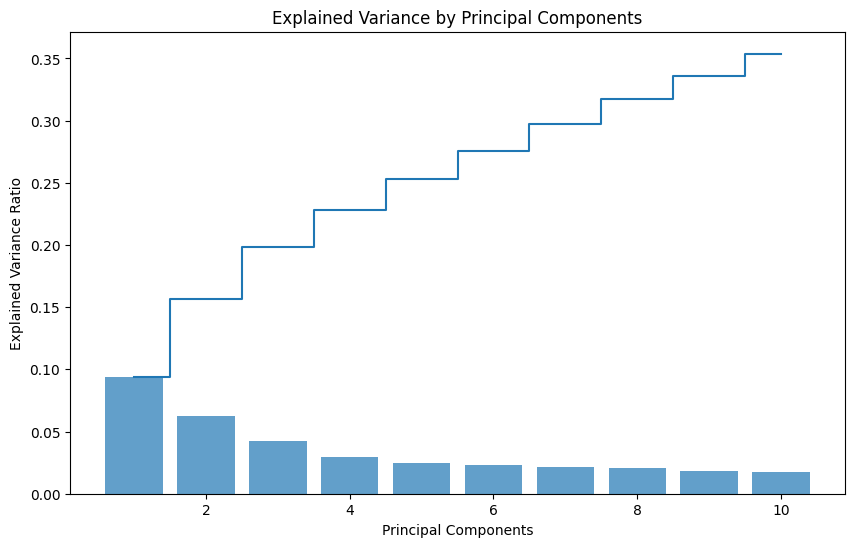

Evaluation Results:
Explained Variance Ratio: [0.09412459 0.06214747 0.04228592 0.02930714 0.024841   0.0231755
 0.02109296 0.02078171 0.01846502 0.01757693]
Cumulative Explained Variance: [0.09412459 0.15627206 0.19855798 0.22786512 0.25270613 0.27588163
 0.29697458 0.3177563  0.33622131 0.35379825]
Reconstruction Error: 0.6462017519581752
Silhouette Score: 0.15595491547078696


/Users/jihoonchung/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [254]:
# Example usage
results_mi_corr = evaluate_pca_indepth(data, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")

## 5.2 Evaluate Feature selection performance

The result look not amazing... so we will be looking into product after the feature selection.
1. Batch Correlation 
2. lazy Correlation 
3. MI-Batch Correlation with top 10 features
4. MI-Batch Correlation with top 50 features
5. MI-lazy Correlation with top 10 features
6. MI-lazy Correlation with top 50 features

### 5.2.1. Batch Correlation 

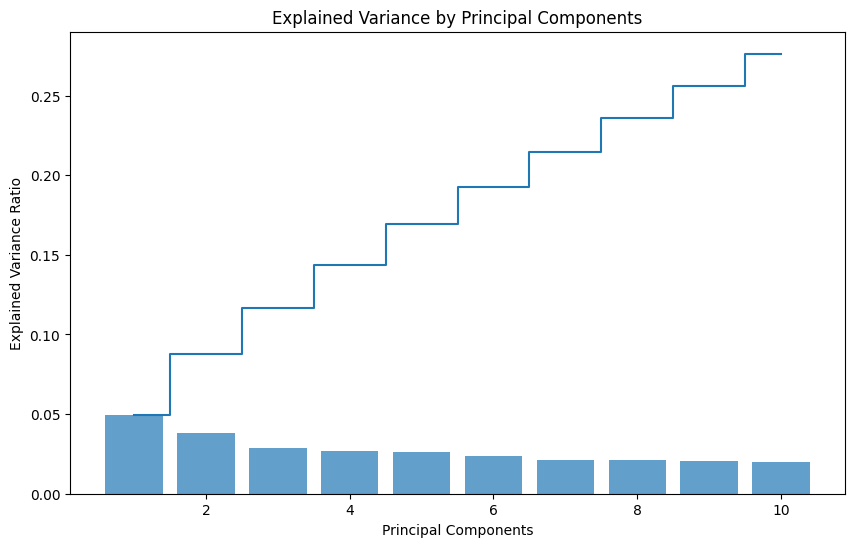

Evaluation Results:
Explained Variance Ratio: [0.04975101 0.03788848 0.02877009 0.02705259 0.02593067 0.02354472
 0.02148111 0.02129391 0.02041904 0.02021021]
Cumulative Explained Variance: [0.04975101 0.08763948 0.11640958 0.14346216 0.16939283 0.19293755
 0.21441866 0.23571256 0.2561316  0.27634182]
Reconstruction Error: 0.7236581843003218
Silhouette Score: 0.2704041461512085


/Users/jihoonchung/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [255]:
# Example usage
results_mi_corr = evaluate_pca_indepth(df, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")

### 5.2.2. lazy Correlation 

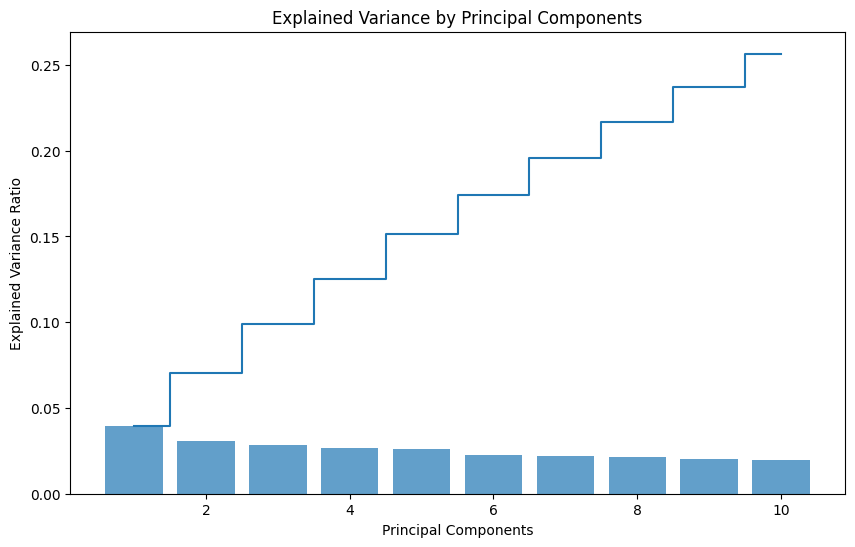

Evaluation Results:
Explained Variance Ratio: [0.03949529 0.03065633 0.02864457 0.02652379 0.02590736 0.02268005
 0.02171989 0.02112519 0.02011415 0.01967141]
Cumulative Explained Variance: [0.03949529 0.07015162 0.09879619 0.12531999 0.15122735 0.1739074
 0.19562729 0.21675247 0.23686662 0.25653803]
Reconstruction Error: 0.7434619686660425
Silhouette Score: 0.07272036647781653


/Users/jihoonchung/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [271]:
# Example usage
results_mi_corr = evaluate_pca_indepth(df_corr, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")

### 5.2.3. MI-Batch Correlation with top 10 features

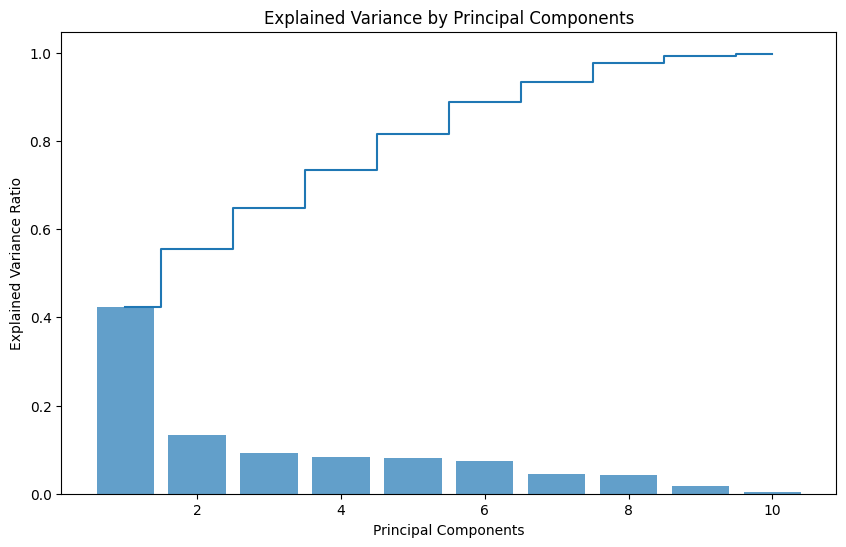

Evaluation Results:
Explained Variance Ratio: [0.42338695 0.13234606 0.0929812  0.08437231 0.08170158 0.07409321
 0.04569356 0.04235338 0.01669707 0.00420177]
Cumulative Explained Variance: [0.42338695 0.55573301 0.64871421 0.73308652 0.8147881  0.88888131
 0.93457487 0.97692825 0.99362532 0.99782709]
Reconstruction Error: 0.0021729081284869545
Silhouette Score: 0.26286717823052475


/Users/jihoonchung/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [275]:
# Example usage
results_mi = evaluate_pca_indepth(df_mi, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi['reconstruction_error']}")
print(f"Silhouette Score: {results_mi['silhouette_score']}")

### 5.2.4. MI-Batch Correlation with top 50 features

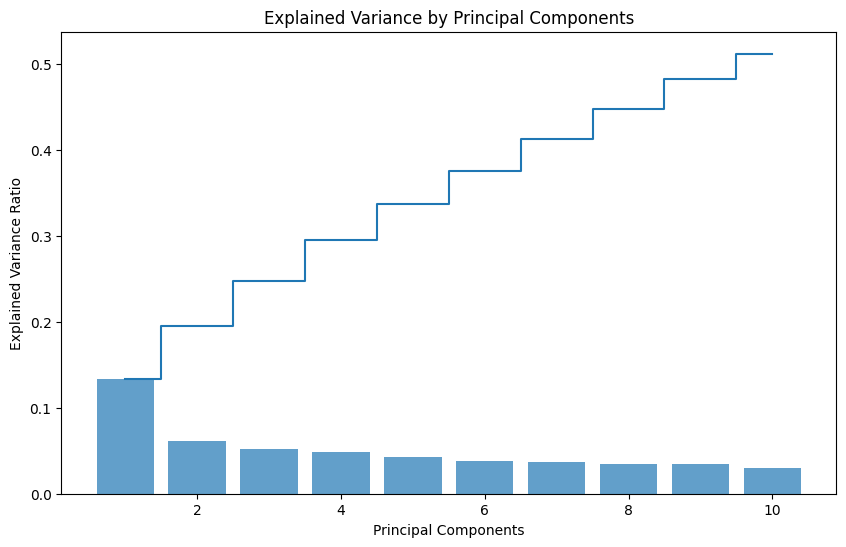

Evaluation Results:
Explained Variance Ratio: [0.13327333 0.06152121 0.05210105 0.04842916 0.04214747 0.03804868
 0.03727893 0.03505209 0.0342169  0.02973082]
Cumulative Explained Variance: [0.13327333 0.19479454 0.24689559 0.29532476 0.33747223 0.37552091
 0.41279984 0.44785193 0.48206883 0.51179966]
Reconstruction Error: 0.48820034499027515
Silhouette Score: 0.11552456989944217


/Users/jihoonchung/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [269]:
# Example usage
results_mi_corr = evaluate_pca_indepth(df_mi_50, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")

### 5.2.5. MI-lazy Correlation with top 10 features

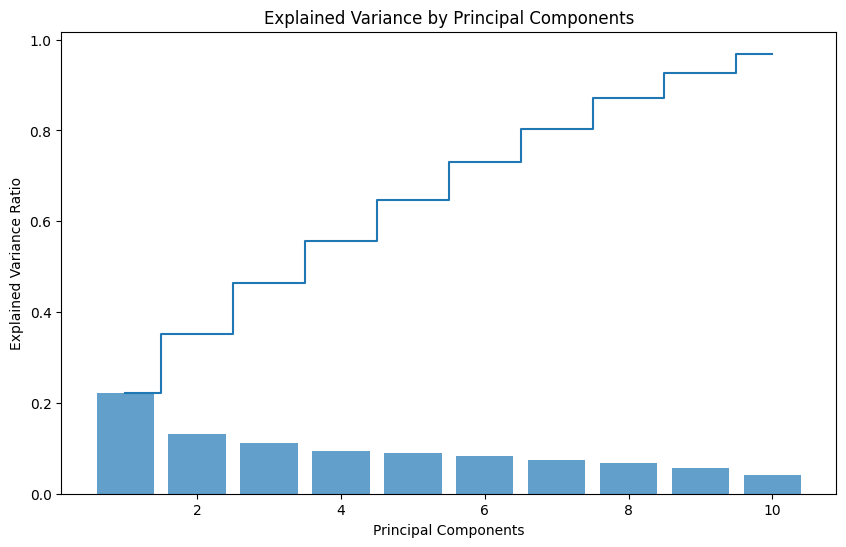

Evaluation Results:
Explained Variance Ratio: [0.22092685 0.13140359 0.11119638 0.09307235 0.08978156 0.08314545
 0.07455379 0.06676113 0.05594382 0.04218168]
Cumulative Explained Variance: [0.22092685 0.35233044 0.46352682 0.55659917 0.64638074 0.72952618
 0.80407997 0.8708411  0.92678491 0.96896659]
Reconstruction Error: 0.03103340956900983
Silhouette Score: 0.21306405869379927


/Users/jihoonchung/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [259]:
# Example usage
results_mi_corr = evaluate_pca_indepth(df_mi_corr, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")


### 5.2.6. MI-lazy Correlation with top 50 features

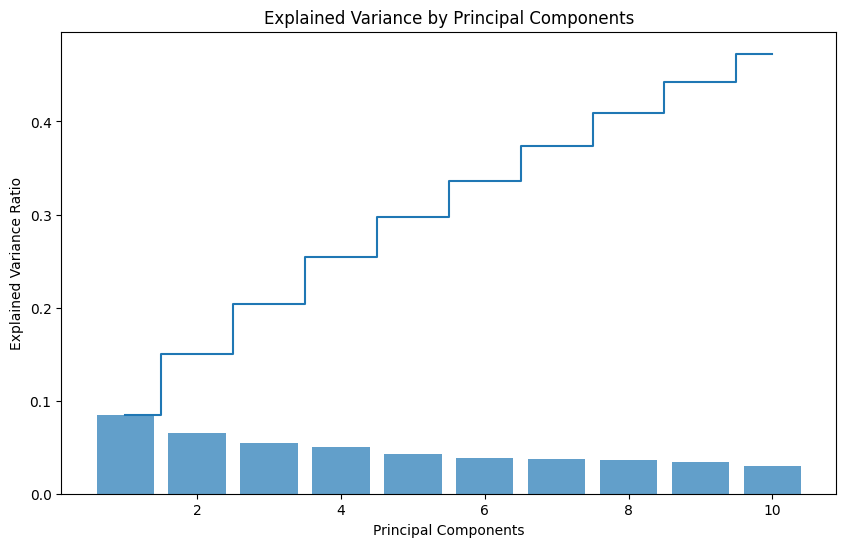

Evaluation Results:
Explained Variance Ratio: [0.08475382 0.0652013  0.05430314 0.04992047 0.04299788 0.0383776
 0.03759253 0.03600004 0.03367373 0.02992244]
Cumulative Explained Variance: [0.08475382 0.14995512 0.20425826 0.25417873 0.29717661 0.33555421
 0.37314674 0.40914678 0.44282051 0.47274295]
Reconstruction Error: 0.527257046041653
Silhouette Score: 0.12012087287487294


/Users/jihoonchung/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [260]:
# Example usage
results_mi_corr = evaluate_pca_indepth(df_mi_corr_50, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")


### 5.2.7. MI-lazy Correlation with top 25 features 

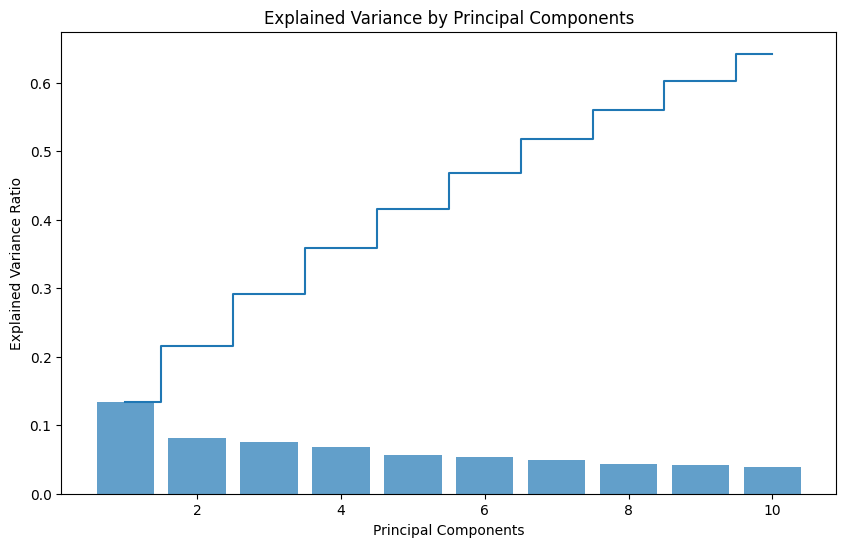

Evaluation Results:
Explained Variance Ratio: [0.42338695 0.13234606 0.0929812  0.08437231 0.08170158 0.07409321
 0.04569356 0.04235338 0.01669707]
Cumulative Explained Variance: [0.42338695 0.55573301 0.64871421 0.73308652 0.8147881  0.88888131
 0.93457487 0.97692825 0.99362532]
Reconstruction Error: 0.0063746803871681515
Silhouette Score: 0.26058286795170704


/Users/jihoonchung/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [266]:
# Example usage
results_mi_corr_25 = evaluate_pca_indepth(df_mi_corr_25, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")


## 5.3 Results analysis

The best one so far was "MI-lazy Correlation with top 10 features"

Overall, the PCA analysis shows effective dimensionality reduction with a good balance between retaining variance and reducing dimensions. The explained variance and reconstruction error indicate that the essential data structure is well-preserved. The silhouette score suggests there is some clustering structure, but it might need further refinement.

In [236]:
df_mi_corr

,23_16800_mean_middle,18_16800_mean_middle,23_6000_mean_middle,28_16800_mean_middle,13_6000_mean_middle,13_3000_mean_middle,13_10000_mean_middle,53_8000_mean_middle,53_6000_mean_middle,53_3000_mean_middle,Sensor ID
0,1302.076923,1069.285714,1328.200000,1590.384615,827.000000,827.000000,827.000000,2995.000000,2995.205128,2995.000000,1
1,1247.560000,954.200000,1235.000000,1522.920000,679.000000,679.000000,679.640000,1891.240000,2951.000000,2945.800000,2
2,1296.674419,1020.920000,1296.511111,1584.244444,717.240000,718.040000,717.880000,2997.320000,3000.440000,2995.400000,3
3,1319.000000,1031.000000,1318.652174,1628.469388,736.920000,737.160000,737.080000,2999.000000,2999.000000,2999.000000,4
4,1332.760000,1045.697674,1332.920000,1587.480000,743.000000,741.880000,743.000000,2110.760000,3034.760000,3045.468085,5
...,...,...,...,...,...,...,...,...,...,...,...
164,1303.240000,429.122449,1299.720000,1570.902439,728.809524,710.680000,704.853659,2998.920000,2996.280000,3005.480000,166
165,729.800000,1021.051282,1303.000000,1569.190476,703.727273,716.600000,712.040000,2992.120000,2993.880000,2983.324324,167
166,1313.320000,1010.314286,1322.288889,1588.860465,726.200000,725.285714,726.120000,3007.260870,3005.720000,2997.160000,168
167,1327.080000,1037.880000,1317.640000,1599.615385,759.000000,760.916667,759.000000,3016.302326,3015.631579,3005.880000,169


one thing that caught attention is the nature of this project is anomaly detection. If a PCA model reconstructs normal data well, it does not necessarily mean it will reconstruct outliers or anomalies well. In fact, the assumption in using reconstruction error for anomaly detection is that the PCA model, which is trained on normal data, will not reconstruct anomalies as well, leading to higher reconstruction errors for anomalous data points.

The Silhouette Score is generally used to evaluate the quality of clustering. While it provides insights into how well-defined clusters are, it is not directly designed for anomaly detection. We have to keep this in mind.

In [268]:
df_mi_corr.to_csv("../processed_data/lazy_corr_MI_10_FS.csv", index=False)
df_mi_corr_50.to_csv("../processed_data/lazy_corr_MI_50_FS.csv", index=False)
df_corr.to_csv("../processed_data/lazy_corr_FS.csv", index=False)
df.to_csv("../processed_data/batch_corr_FS.csv", index=False)

# 6.0 Inspect data to verify the preliminary result

In this section we will try to invesitage data point that were seems to be outlier from "MI-lazy Correlation with top 10 features".

In [272]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Load the dataset
file_path = '../processed_data/all_data_v4-1-1_cleaned_sensor170.csv'
all_cleaned_df = pd.read_csv(file_path)
all_cleaned_df = all_cleaned_df.drop("Unnamed: 0",axis=1)
all_cleaned_df.head()

,Trial,Ping Duration,Distance (cm),Ping Time (us),Delay (us),Steps,Arduino ID,Sensor ID,Range (cm),Sensor length (cm),...,side a (cm),side b (cm),side c (cm),Angle on YZ plane,Sensor Configuration,Sensor Angle,Surface material,Surface Length (cm),Surface Width (cm),side g (cm)
0,0,3416,13.25,755,16800,11223.0,1,51,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
1,1,3400,12.82,731,16800,11223.0,1,51,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
2,2,3432,13.32,759,16800,11223.0,1,51,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
3,3,3424,13.32,759,16800,11223.0,1,51,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN
4,4,3428,13.25,755,16800,11223.0,1,51,13,0.8,...,18.3,18.3,0,0,HTR,90,wood,31,30.5,NaN


In [273]:
# Function to visualize the effect of delay and range on ping time
def visualize_effect_on_ping_time_sensors(df, target = 0):
    """
    Visualize the effect of delay and range on ping time.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    """
    # Group by sensor ID, delay, and range, then calculate the mean ping time
    grouped_df = df.groupby(['Sensor ID', 'Delay (us)', 'Range (cm)'])['Ping Time (us)'].mean().reset_index()
    # Create individual plots for each range
    unique_sensors = grouped_df['Sensor ID'].unique()
    
    if target in unique_sensors:
        subset_df = grouped_df[grouped_df['Sensor ID'] == target]
        plt.figure(figsize=(14, 10))
        sns.barplot(
            x='Range (cm)', 
            y='Ping Time (us)', 
            hue='Delay (us)', 
            data=subset_df
        )
        
        plt.title(f'Effect of Delay on Ping Time by Range on Sensor {target}')
        plt.xlabel('Range (cm)')
        plt.ylabel('Mean Ping Time (us)')
        plt.legend(title='Delay (us)')
        plt.xticks(rotation=45)
        # Adjust y-axis limits and ticks for better precision
        min_ping_time = subset_df['Ping Time (us)'].min()
        max_ping_time = subset_df['Ping Time (us)'].max()
        plt.ylim(min_ping_time - 50, max_ping_time + 50)  # Adjust the limits as needed
        plt.yticks(range(int(min_ping_time) - 50, int(max_ping_time) + 50, 50))  # Adjust the step as needed
        plt.show()

def visualize_lineplot_ping_time_with_variability(df, target = []):
    """
    Visualize the effect of range on ping time for each delay separately with variability.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    """
    # Group by sensor ID, delay, and range, then calculate the mean and standard deviation of ping time
    grouped_df = df.groupby(['Sensor ID', 'Delay (us)', 'Range (cm)']).agg(
        mean_ping_time=('Ping Time (us)', 'mean'),
        std_ping_time=('Ping Time (us)', 'std')
    ).reset_index()

    target_df = grouped_df[grouped_df['Sensor ID'].isin(target)]
    # Get unique delays
    unique_delays = target_df['Delay (us)'].unique()

    for delay in unique_delays:
        subset_df = target_df[target_df['Delay (us)'] == delay]

        fig = px.line(
            subset_df,
            x='Range (cm)',
            y='mean_ping_time',
            color='Sensor ID',
            markers=True,
            title=f'Effect of Range on Ping Time for Delay {delay} us with Variability'
        )

        # Adding error bars
        for sensor_id in subset_df['Sensor ID'].unique():
            sensor_data = subset_df[subset_df['Sensor ID'] == sensor_id]
            fig.add_trace(
                go.Scatter(
                    x=sensor_data['Range (cm)'],
                    y=sensor_data['mean_ping_time'],
                    mode='lines+markers',
                    name=f'Sensor {sensor_id}',
                    error_y=dict(
                        type='data',
                        array=sensor_data['std_ping_time'],
                        visible=True
                    )
                )
            )

        # Plot reference line
        ranges = np.linspace(subset_df['Range (cm)'].min(), subset_df['Range (cm)'].max(), 100)
        reference_ping_times = 57 * ranges
        fig.add_trace(
            go.Scatter(
                x=ranges,
                y=reference_ping_times,
                mode='lines',
                line=dict(color='red', dash='dash'),
                name='Reference Line'
            )
        )

        fig.update_layout(
            xaxis_title='Range (cm)',
            yaxis_title='Mean Ping Time (us)',
            legend_title='Sensor ID',
            template='plotly_white'
        )

        fig.show()
    

## 6.1 Look sensor result based on "MI-lazy Correlation with top 10 features"

From the visual inspecting the section 5.2.5 visualiation there were few things should be investigated.

1. sensor 20, and 75  seems to be outliers
2. Sensor 84,32, 100, 90 seems to form a strong community
3. Sensor 55, 76 and 61 seems to form a weak cluster
4. Sensor 68, 9 and 97 may have form a cluster
5. Sensor 6, and 58 may have form a cluster

After these individual point's investigation I will proceed further with comparing how each of those different from other "community".

Top 10 features are followings:

['23_16800_mean_middle', '18_16800_mean_middle', '13_6000_mean_middle',
'13_3000_mean_middle', '23_6000_mean_middle', '18_3000_mean_middle',
'28_16800_mean_middle', '53_8000_mean_middle', '13_10000_mean_middle',
'53_6000_mean_middle', 'Sensor ID']

### Outlier Investigation: Sensor ID 20,and 75

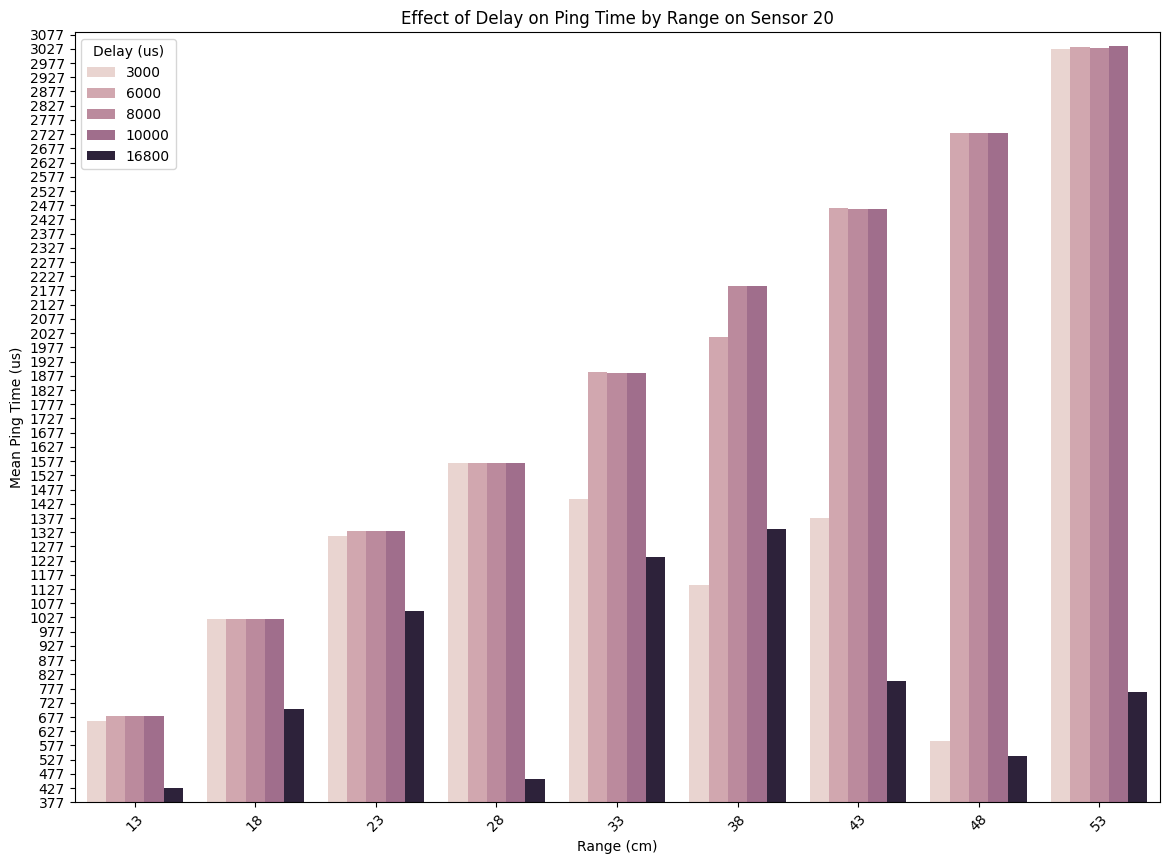

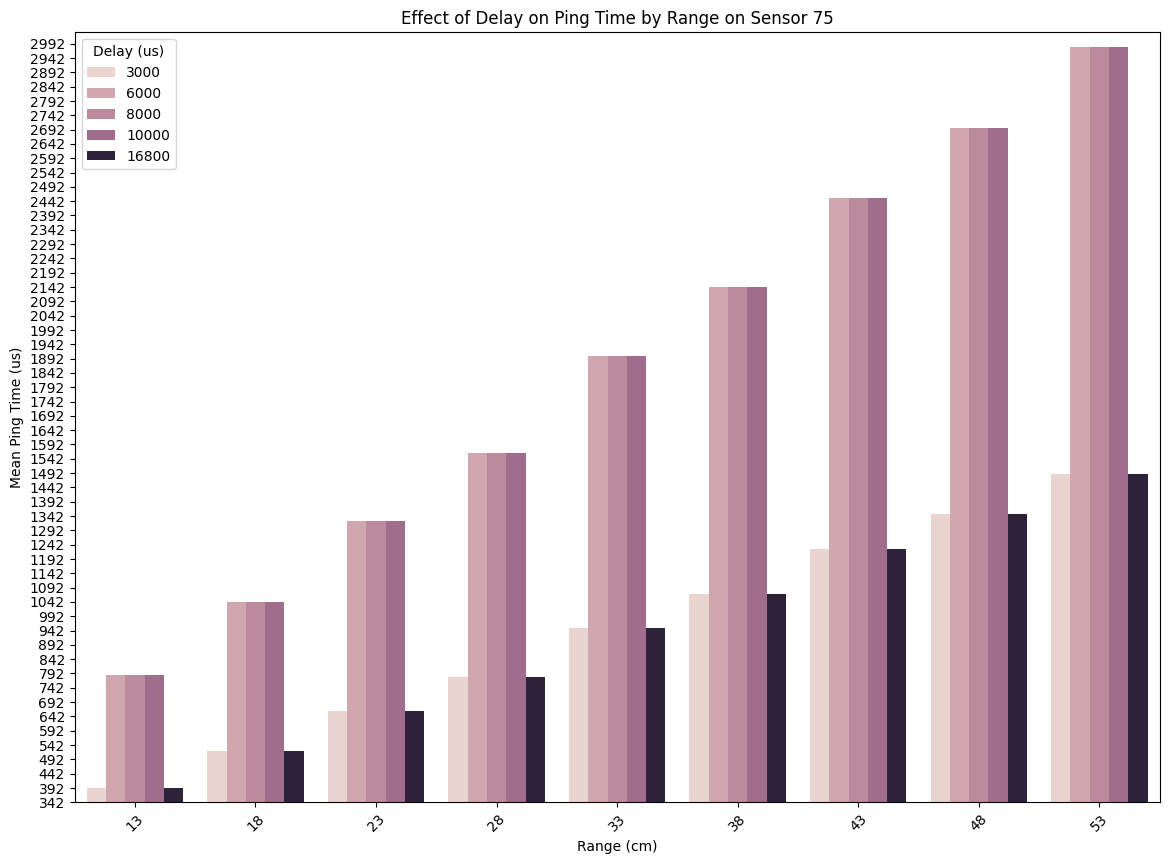

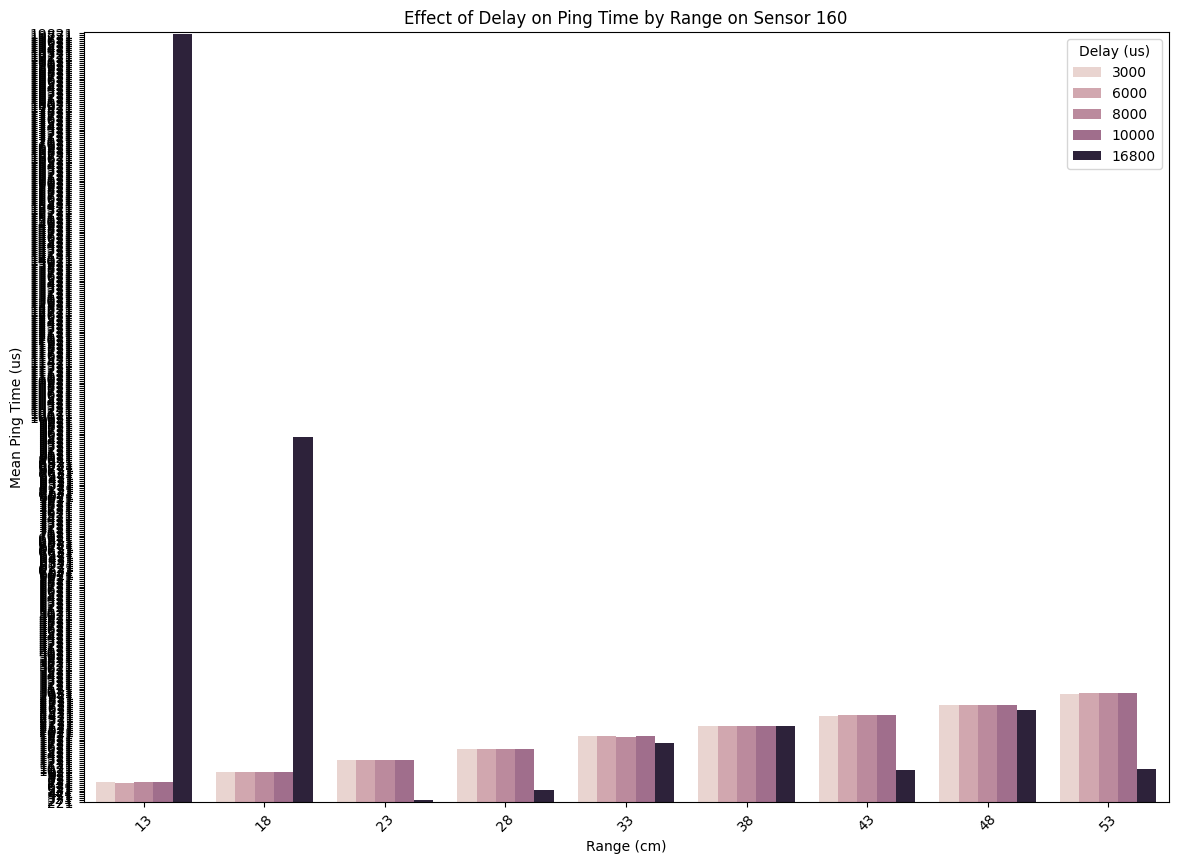

In [274]:
outlier_list = [20,75,160]
for sensor_id in outlier_list:
    visualize_effect_on_ping_time_sensors(all_cleaned_df,sensor_id)

In [246]:
visualize_lineplot_ping_time_with_variability(all_cleaned_df,outlier_list)

Characteristic of the variability are prominent when the delay is 16800us, 6000us, 3000us.

### Strong Community: Sensor 84,32, 100, 90

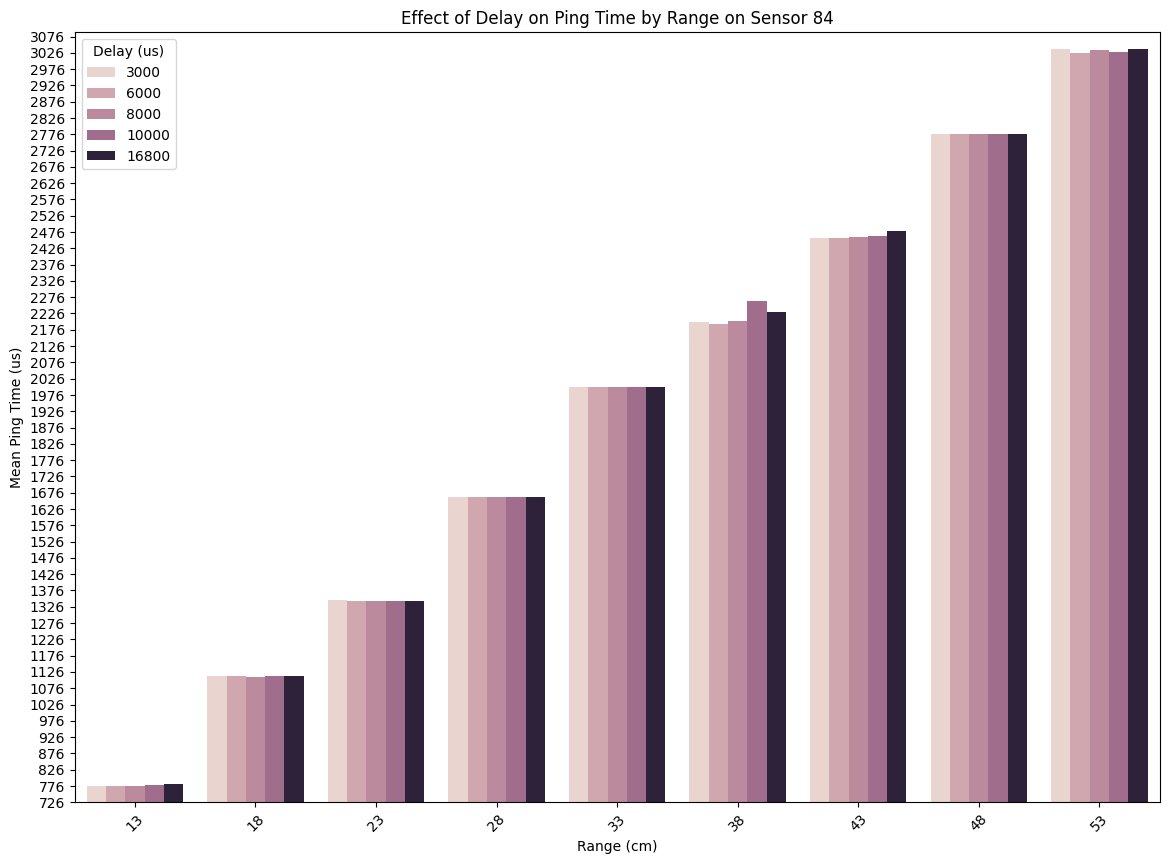

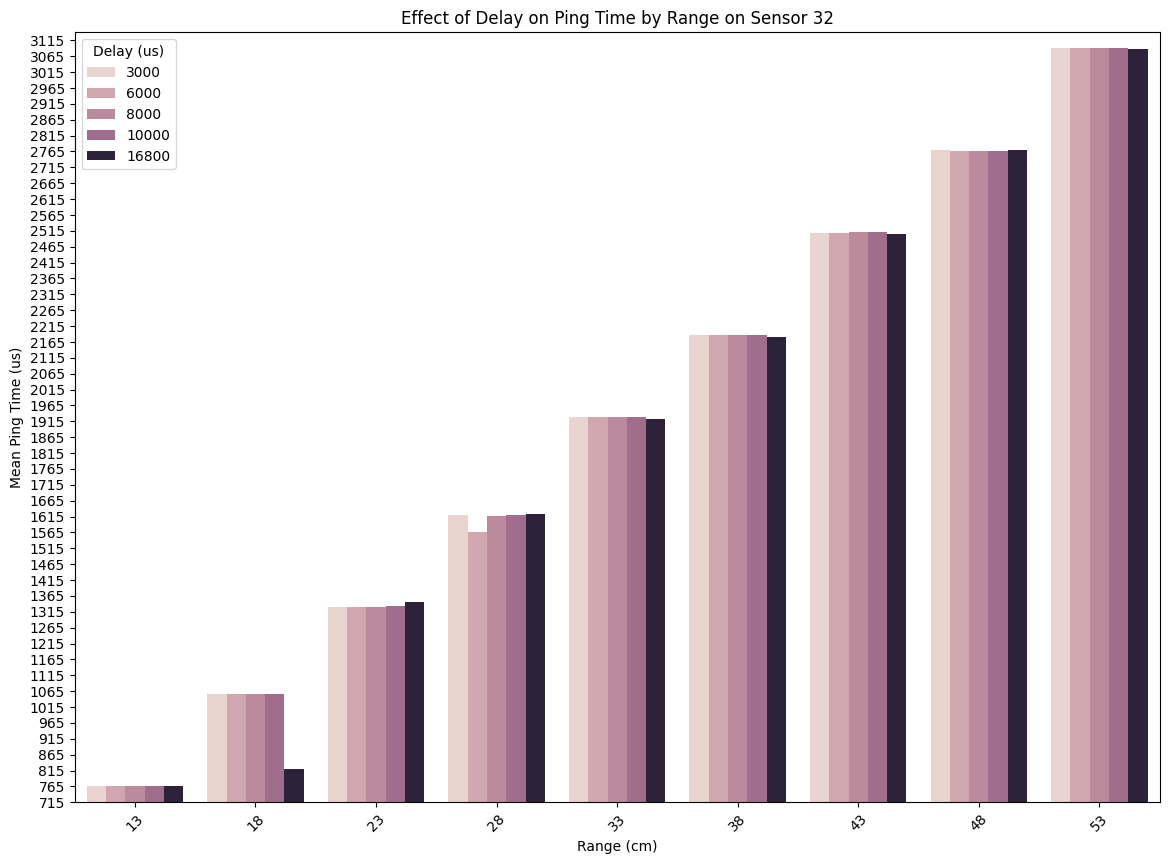

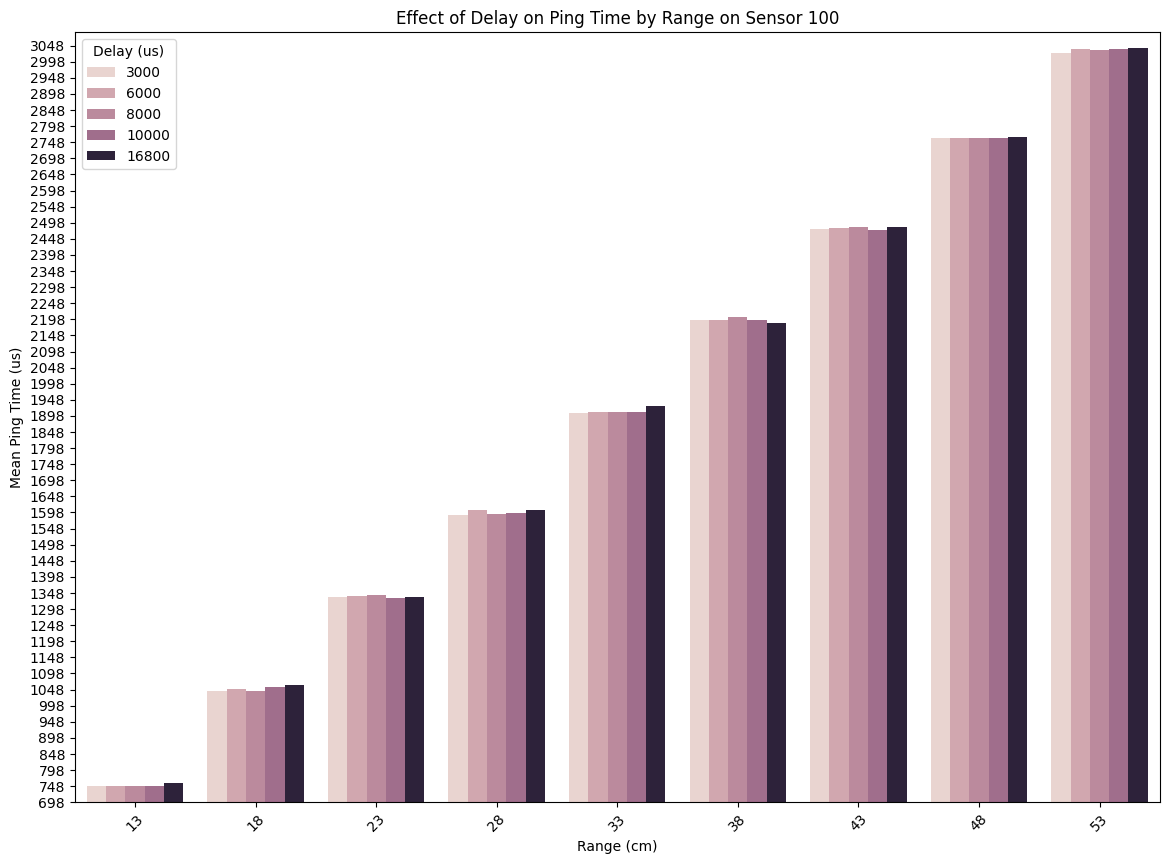

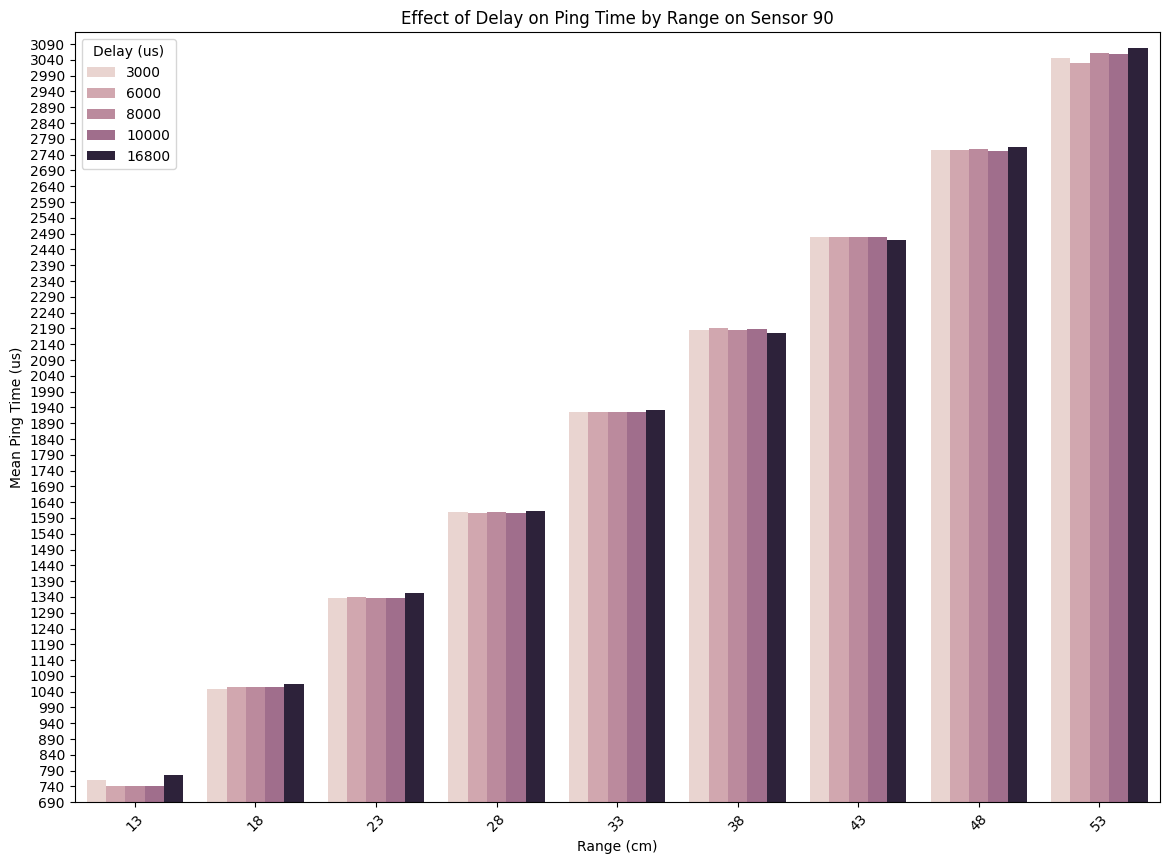

In [ ]:
strong_community = [84,32, 100, 90]
for sensor_id in strong_community:
    visualize_effect_on_ping_time_sensors(all_cleaned_df,sensor_id)

In [ ]:
visualize_lineplot_ping_time_with_variability(all_cleaned_df,strong_community)

They seems to have strong lienar relationship however sensor 32 have some malfunction when the range is close but in general they seems to be similar. However it is bit worrying that sensor 32 seems to be forming a cluster with the others.

**Feature engineering idea:** I can do another feature engineering where index = range_delay_mean_quarltile * range_delay_freq_quarltile

### Weak cluster1: Sensor 55, 76 and 61

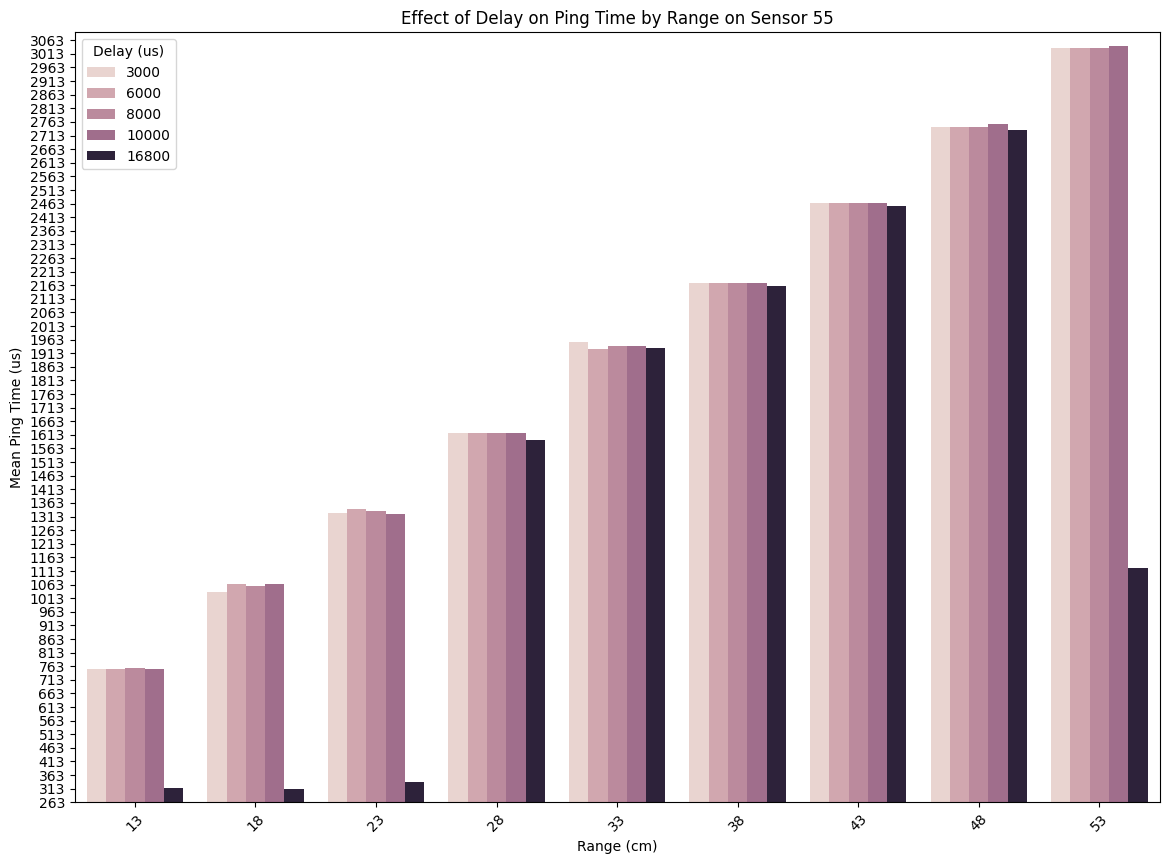

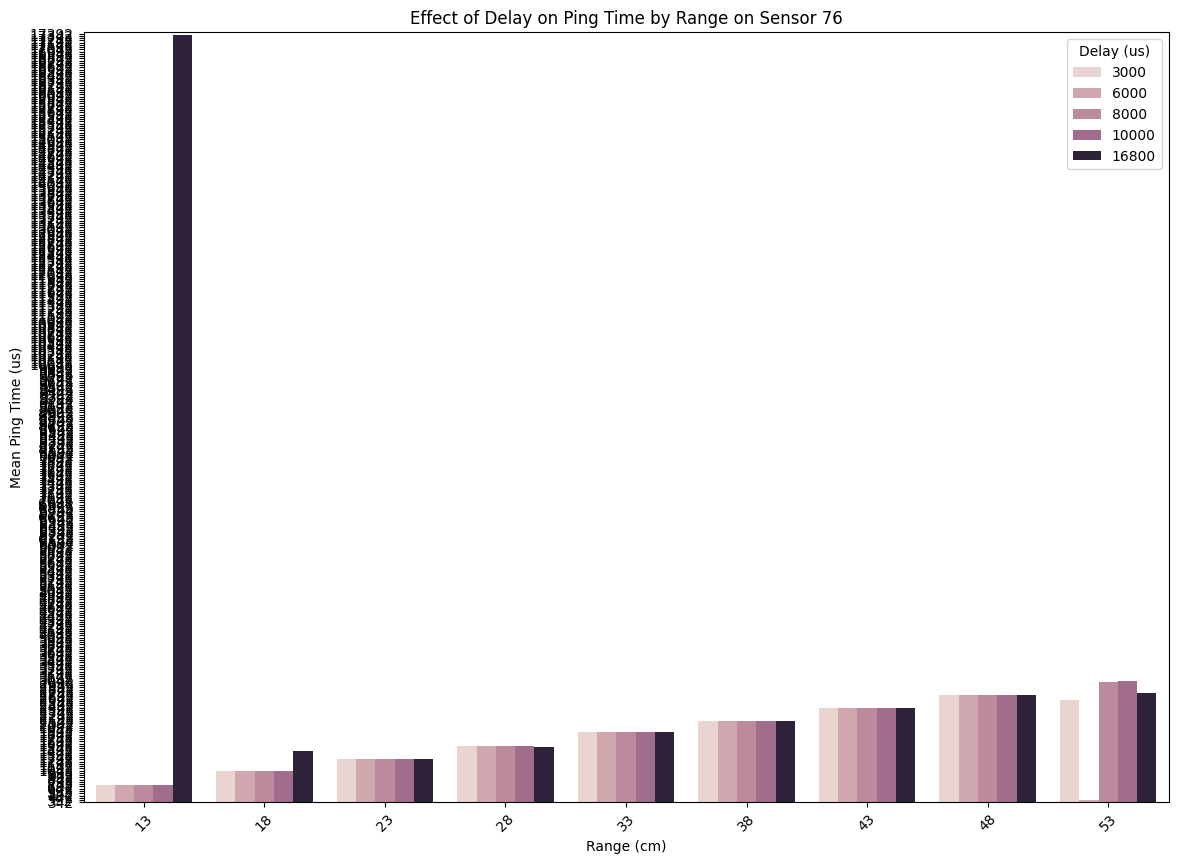

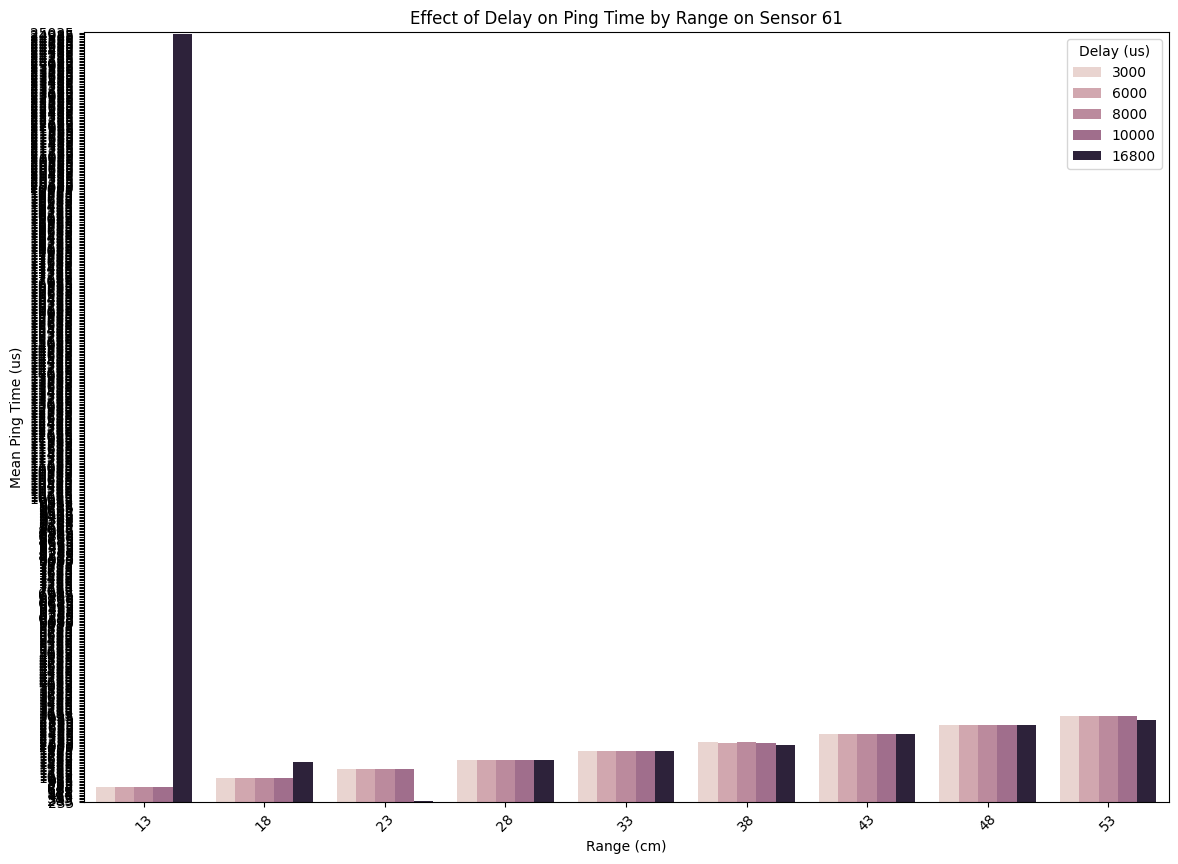

In [ ]:
weak_community_1 = [55,76,61]
for sensor_id in weak_community_1:
    visualize_effect_on_ping_time_sensors(all_cleaned_df,sensor_id)

In [ ]:
visualize_lineplot_ping_time_with_variability(all_cleaned_df,weak_community_1)

This cluster seems reasonable for the delay 16800us where in close range they act weird output and they tend to overestimate things. However sensor 76 on 3000us and 6000us they seems to have abnormal result and I dont think they are accounting this factor. 

### Weak cluster2: Sensor 68, 9 and 97 

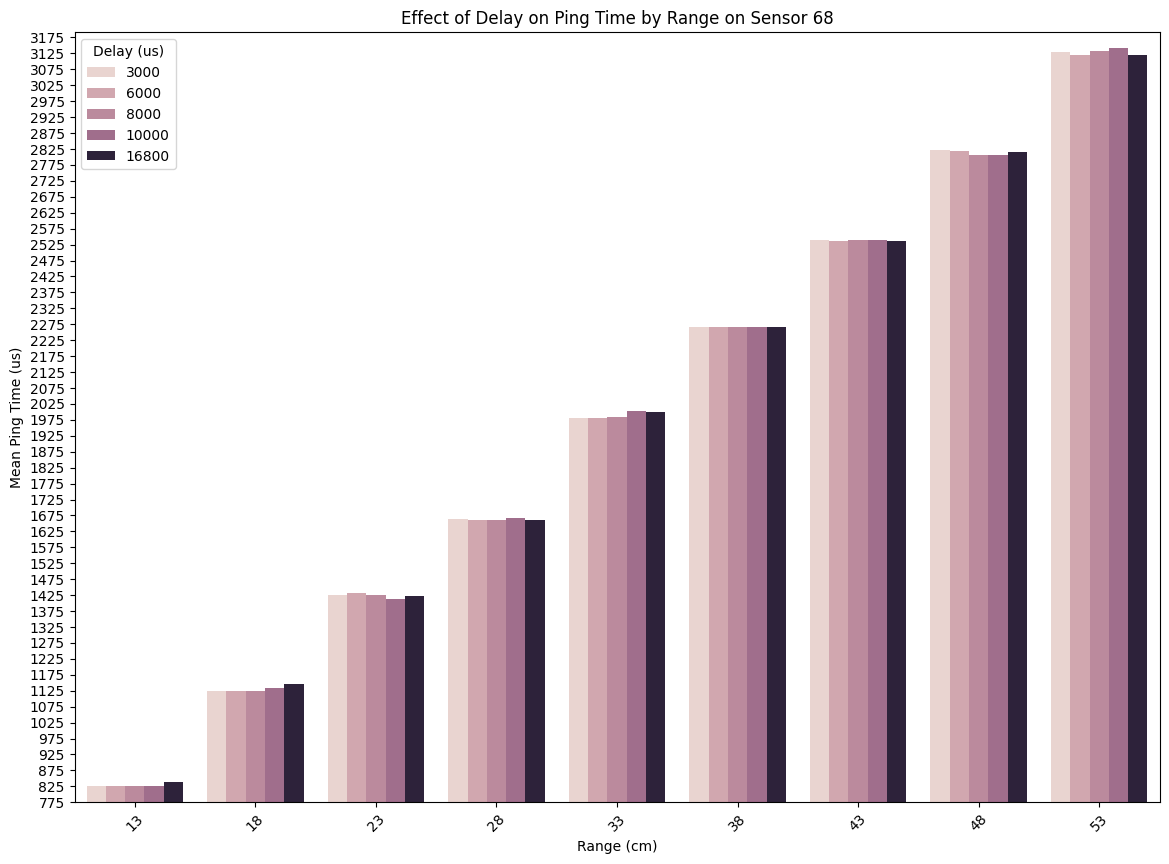

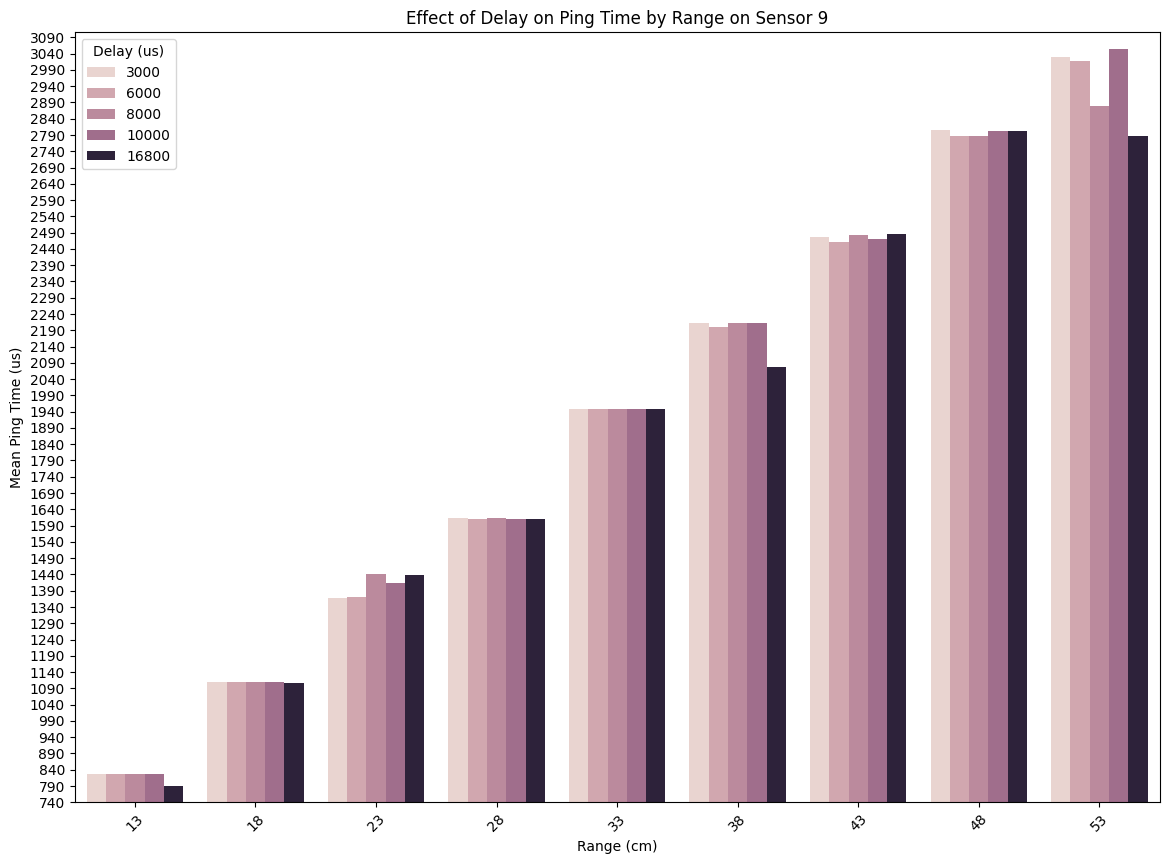

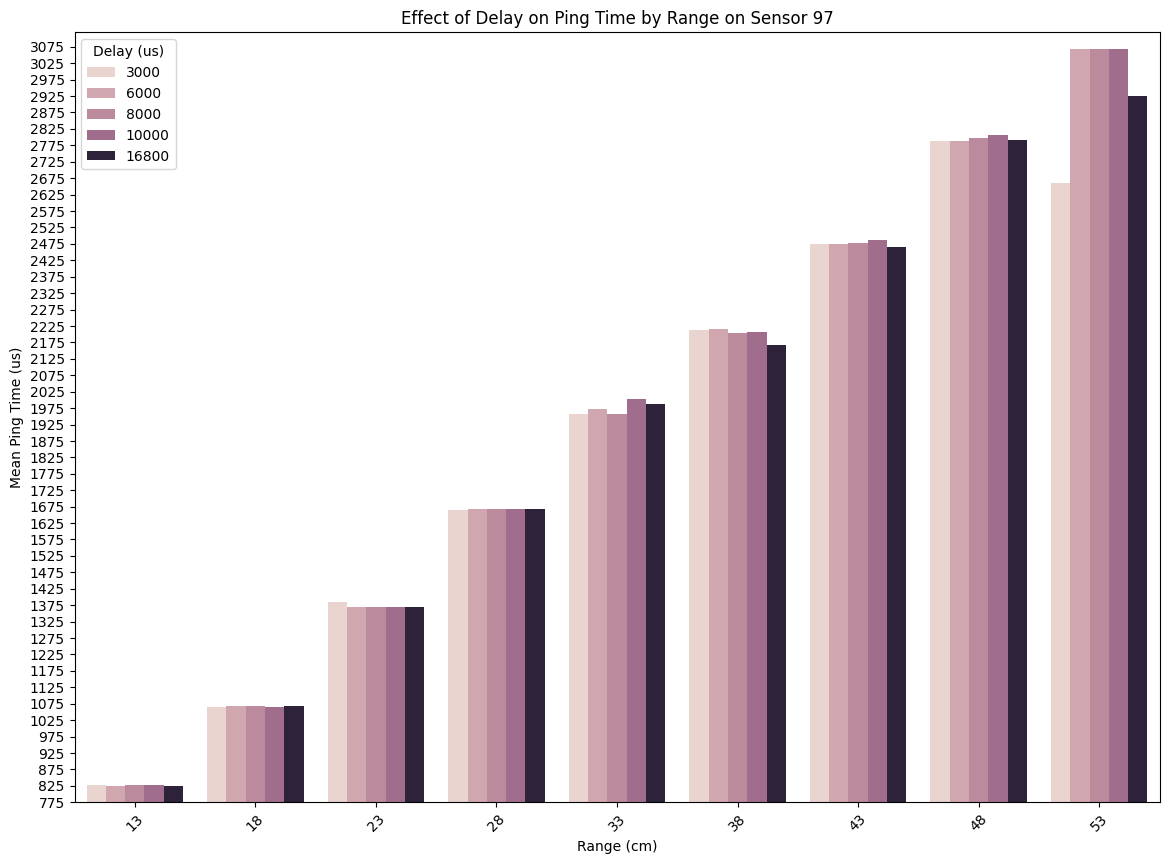

In [ ]:
weak_community_2 = [68, 9, 97 ]
for sensor_id in weak_community_2:
    visualize_effect_on_ping_time_sensors(all_cleaned_df,sensor_id)

In [ ]:
visualize_lineplot_ping_time_with_variability(all_cleaned_df,weak_community_2)

This cluster is the sensor that are overestimating and seems like the cluster correctly capture the characteristics.

### Weak cluster3: Sensor 6, and 58

In [ ]:
weak_community_2 = [58,6 ]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,weak_community_2)

This may have been human error since theres only 3 dimension we can look at which lead me to investigate sophisticated clustering methods.

## 6.2 Look sensor result based on "MI-batch Correlation with top 10 features"

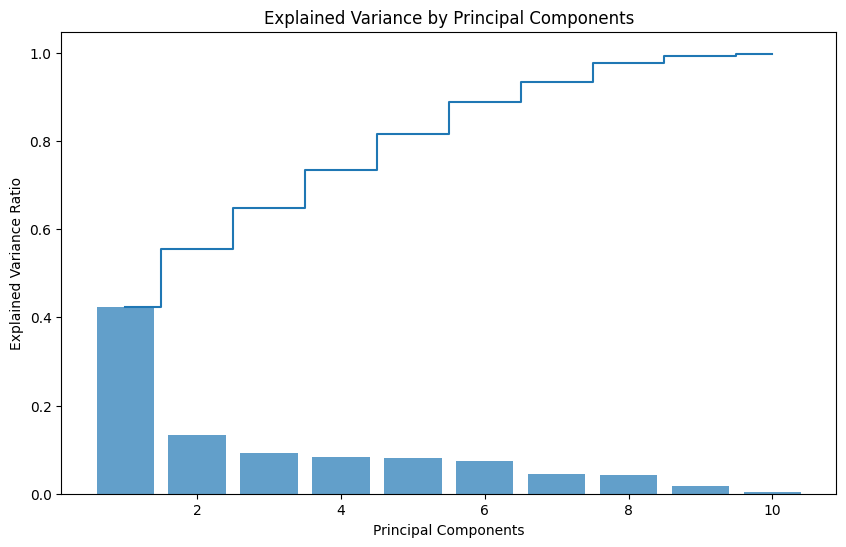

/Users/jihoonchung/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [276]:
# Example usage
results_mi = evaluate_pca_indepth(df_mi, n_components=10, color_column='Sensor ID', n_clusters=3)

From the visual inspecting the section 5.2.3 visualiation there were few things should be investigated.

1. Outlier: sensor 68, 9, 55,75, 163, 2,34
2. Strong community Upper left: 152,147,153,165
3. Strong community Lower left: 18,14,41,48
4. Strong community Lower right: 11,23,29,16
5. Strong community (0,3.8): 65,70,81,1,10
6. Weak community (-2,2): 124,64,146,122
7. Weak community (-4.5,-1.8): 94,86,77,47


After these individual point's investigation I will proceed further with comparing how each of those different from other "community".

### 1. Outlier: sensor 68, 9, 55,75, 163, 2,34

In [277]:
outliers = [68, 9, 55,75, 163, 2,34 ]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,outliers)

### 2. Strong community Upper left: 152,147,153,165


In [278]:
Strong_community_Upper_left = [152,147,153,165 ]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,Strong_community_Upper_left)

### 3. Strong community Lower left: 18,14,41,48


In [281]:
Strong_community_Lower_left = [18,14,41,48]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,Strong_community_Lower_left)

### 4. Strong community Lower right: 11,23,29,16

In [282]:
Strong_community_Lower_rgiht = [11,23,29,16]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,Strong_community_Lower_rgiht)

### 5. Strong community (0,3.8): 65,70,81,1,10


### 6. Weak community (-2,2): 124,64,146,122


### 7. Weak community (-4.5,-1.8): 94,86,77,47